In [2]:
import pandas as pd
import random

ec_df = pd.read_excel('PRS-europa_smap.xlsx', skiprows=1).drop_duplicates()
df = pd.read_csv('author_dataset_europa_smap.csv')
df = df.drop_duplicates()
df = df[df.group!='na']
group1, group2 = random.sample(list(df.group.unique()), 2)

user_dictionary = {}
for i in range(len(df['author_id'])):
    user_dictionary[df['author_name'].values[i]] = df['author_id'].values[i]
user_dictionary

{'Harry Figueroa': 'figueroa',
 'Tushar Shenoy': 'tthrivik',
 'Hunter Rainen': 'hrainen',
 'Michael Thielman': 'thielman',
 'Ricky Graves': 'rdgraves',
 'Leticia Montanez': 'leticia',
 'Barry Volain': 'bvolain',
 'Carl Bruce': 'cbrucejr',
 'Joshua Berman': 'jberman',
 'Katherine Dang': 'kdang',
 'Brendon Palmer': 'bpalmer',
 'John Waters': 'jjwaters',
 'Matthew Vis': 'mvis',
 'Mehran Amrbar': 'mamrbar',
 'Michelle Zhong': 'mzhong',
 'Kevin Wheeler': 'kwheeler',
 'Marshall Smart': 'mcsmart',
 'Shana Worel': 'sworel',
 'Marc Lane': 'mlane',
 'Chaitali Parashare': 'cparasha',
 'Gary Esparza': 'gesparza',
 'Tim Yamasaki': 'yamasaki',
 'Mark Fischman': 'mafisch',
 'Branden Kahn': 'bkahn',
 'Elvis Merida': 'emerida',
 'Michael Underhill': 'mlunderh',
 'Arthur Mastropietro': 'ajmastro',
 'Emmanuel Decrossas': 'edecross',
 'Garett Sohl': 'gsohl',
 'Robert Sharrow': 'rsharrow',
 'Valeria Salazar': 'vsalazar',
 'Lloyd Manglapus': 'lmanglap',
 'Virginia Ford': 'vford',
 'Karthik Srinivasan': 'ksr

In [3]:
group1_anomalies = list(df[df.group==group1].anomaly_id.values)
group2_anomalies = list(df[df.group==group2].anomaly_id.values)
g1a_sample = int(random.choice(group1_anomalies).split('_')[-2])
g2a_sample = int(random.choice(group2_anomalies).split('_')[-2])
g1a_sample, g2a_sample

(211487, 201499)

In [4]:
from openpyxl import load_workbook
import pandas as pd

In [5]:
data_file = 'PRS-europa_smap.xlsx'
# data_file = 'prs_data/PRS-Psyche.xlsx'
wb = load_workbook(data_file)
ws = wb['PRS Search Results Export']
all_rows = list(ws.rows)

In [6]:
from dgl.nn import SAGEConv
from dgl import mean_nodes, max_nodes
import dgl.function as fn

import torch
import torch.nn as nn
import torch.nn.functional as F

In [7]:
import dgl
import torch

class GraphDataset():
    def __init__(self):
        super(GraphDataset, self).__init__()
        
        self.G = dgl.DGLGraph()
        self.G_dict = {}

        self.node_types = {
            'Paragraph': torch.tensor([0]),
            'Document': torch.tensor([1]),
            'Project': torch.tensor([2]),
            'Title': torch.tensor([3]),
            'Subsystem': torch.tensor([4]),
            'Problem Area' : torch.tensor([5]),
            'Problem Type' : torch.tensor([6]),
            'Author' : torch.tensor([7])
        }

        self.edge_types = {
            'PARA_DOC': 0, #paragraph -> document (correct)
            'DOC_PROJ': 1, #document -> project
            'TITLE_DOC': 2, # title -> document
            'SUBSYSTEM_DOC' : 3, #subsystem -> document
            'PROB_AREA_DOC' : 4, #problem area -> document
            'PROB_TYPE_DOC' : 5, #problem type -> document
            'DOC_AUTHOR' : 6, #document -> author
            'AUTHOR_DOC' : 7 #author -> document
        }
        
    def subgraph(self, nodes):
        return dgl.node_subgraph(self.G, nodes)
        
    def add_node(self, feat, label, params=None):
        if params == None:
            params = {"attr": feat, 'label':self.node_types[label]}
            
        if len(feat.shape) != 2 or feat.shape[0] != 1:
            print("ERROR: Input should be in form (1, num_feat)")
        else:
            self.G_dict[self.G.num_nodes()+1] = params
            self.G.add_nodes(1, {'attr': feat, 'label':self.node_types[label]})
            
        return 
    
    def add_edge(self, u, v, weight=1.0):
        #TODO: Will we have features for edges?
        self.G.add_edges(u, v, {'attr': torch.tensor([weight])})

    def check_edge(self, u, v):
        a = self.G.has_edges_between(u, v)
        return (a[0]==0)

In [8]:
from tika import parser
import glob
from models2 import Embedder
import re
import cleantext

emb = Embedder.DocumentEmbedder()

# function to embed text from each cell, returns embedding
def embed_para(emb,cleaned_text):

    #Process input
    cleaned_text = cleaned_text.lower()
    cleaned_text = cleaned_text.replace('&nbsp;', ' ').replace('&amp;', ' ').replace('&quot;',' ')
    cleaned_text = cleantext.replace_emails(cleaned_text, replace_with=' ')

    doc_embedding=emb.create_document_embedding(cleaned_text, '. ')
    return doc_embedding

c:\Users\subramani\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [343]:
# create graph
dataset = GraphDataset()

people_dictionary = {}

subsystem_dictionary = {}
problem_dictionary = {}
suspected_problem_area_dictionary = {}

node_counter=0
node_dictionary={}

project_dictionary = {}

label_dictionary = {}

color_map = []

edge_features = []

num_rows = len(all_rows)
num_cols = len(all_rows[0])

for i in range(2,num_rows): #iterate over rows (separate anomalies)
# for i in range(2,20):
    print(f"progress: {100*i/2321}")

    if all_rows[i][0].value is None or all_rows[i][0].value=='':
        break

    prs_node = {}
    title_node = {}

    para_nodes=[]
    person_nodes=[]
    subsystem_nodes=[]
    problem_nodes=[]
    problem_area_nodes=[]

    for j in range(num_cols): #iterate over columns
        
        prs_node[all_rows[1][j].value] = all_rows[i][j].value

        # columns to include as paragraphs
        include_columns = ['Description of Incident', 'Executive Summary','Test Verification','Verification and Analysis']#,'Review Comments']


        if all_rows[i][j].value is not None and all_rows[i][j].value != '' and all_rows[1][j].value in include_columns:
            para_node = {
                'paragraph': all_rows[i][j].value,
                'parent_prs': all_rows[i][0].value,
                'node_type': 'paragraph node',
                'node_id': node_counter
            }

            node_name = all_rows[1][j].value + ' ' + str(all_rows[i][0].value)
            node_dictionary[node_name] = para_node

            tensor = embed_para(emb, all_rows[i][j].value).unsqueeze(0)
            dataset.add_node(tensor,'Paragraph')
            para_nodes.append(node_counter)

            label_dictionary[node_counter] = node_name
            color_map.append('blue')

            node_counter+=1
            # node id = dataset.G.num_nodes()

        #-----------CODE FOR AUTHOR NODES------------------------

        # create author nodes
        people_cols = ['Assigned To', 'Originated By', 'Responsible Engineer/Team Lead']

        if all_rows[1][j].value in people_cols and all_rows[i][j].value not in people_dictionary and all_rows[i][j].value in user_dictionary.keys():
            person_node = {
                'name': all_rows[i][j].value,
                'parent_prs': [all_rows[i][0].value],
                'node_type': 'person node',
                'node_id': node_counter
            }

            node_name = user_dictionary[all_rows[i][j].value]
            node_dictionary[node_name] = person_node

            people_dictionary[all_rows[i][j].value] = node_counter
            
            dataset.add_node(torch.zeros(1,768),'Author')
            person_nodes.append(node_counter)

            label_dictionary[node_counter] = node_name
            color_map.append('orange')

            node_counter+=1

        elif all_rows[1][j].value in people_cols and all_rows[i][j].value in people_dictionary:
            user = user_dictionary[all_rows[i][j].value]
            if all_rows[i][0].value not in node_dictionary[user]['parent_prs']:
               node_dictionary[user]['parent_prs'].append(all_rows[i][0].value)
            person_nodes.append(people_dictionary[all_rows[i][j].value])
        #----------------------------------------------------------------------

        #create subsystem nodes
        if all_rows[1][j].value == 'Subsystem Item' and not all_rows[i][j].value is None and not all_rows[i][j].value == '':
            if all_rows[i][j].value not in subsystem_dictionary:
                subsystem_node = {
                    'name': all_rows[i][j].value,
                    'parent_prs': [all_rows[i][0].value],
                    'node_type': 'subsystem node',
                    'node_id': node_counter
                }

                node_name = all_rows[i][j].value
                node_dictionary[node_name] = subsystem_node

                subsystem_dictionary[node_name] = node_counter

                tensor = embed_para(emb, all_rows[i][j].value).unsqueeze(0)
                dataset.add_node(tensor,'Subsystem')
                subsystem_nodes.append(node_counter)

                label_dictionary[node_counter] = node_name
                color_map.append('yellow')

                node_counter += 1

            else:
                if all_rows[i][0].value not in node_dictionary[all_rows[i][j].value]['parent_prs']:
                    node_dictionary[all_rows[i][j].value]['parent_prs'].append(all_rows[i][0].value)
                subsystem_nodes.append(subsystem_dictionary[all_rows[i][j].value])

            # create problem type nodes
        if all_rows[1][j].value == 'Problem Type' and not all_rows[i][j].value is None and not all_rows[i][j].value == '':
            if all_rows[i][j].value not in problem_dictionary:
                problem_node = {
                    'name': all_rows[i][j].value,
                    'parent_prs': [all_rows[i][0].value],
                    'node_type': 'problem node',
                    'node_id': node_counter
                }

                node_name = all_rows[i][j].value
                node_dictionary[node_name] = problem_node

                problem_dictionary[node_name] = node_counter

                tensor = embed_para(emb, all_rows[i][j].value).unsqueeze(0)
                dataset.add_node(tensor,'Problem Type')
                problem_nodes.append(node_counter)

                label_dictionary[node_counter] = node_name
                color_map.append('purple')

                node_counter += 1
            
            else:
                if all_rows[i][0].value not in node_dictionary[all_rows[i][j].value]['parent_prs']:
                    node_dictionary[all_rows[i][j].value]['parent_prs'].append(all_rows[i][0].value)
                problem_nodes.append(problem_dictionary[all_rows[i][j].value])

        # create for "Suspected Problem Area" which includes Procedural, Hardware, and Software
        if all_rows[1][j].value == 'Suspected Problem Area' and not all_rows[i][j].value is None and not all_rows[i][j].value == '':
            if all_rows[i][j].value not in suspected_problem_area_dictionary:
                suspected_problem_area_node = {
                    'name': all_rows[i][j].value,
                    'parent_prs': [all_rows[i][0].value],
                    'node_type': 'suspected problem area node',
                    'node_id': node_counter
                }

                node_name = all_rows[i][j].value
                node_dictionary[node_name] = suspected_problem_area_node

                suspected_problem_area_dictionary[node_name] = node_counter

                tensor = embed_para(emb, all_rows[i][j].value).unsqueeze(0)
                dataset.add_node(tensor,'Problem Area')
                problem_area_nodes.append(node_counter)

                label_dictionary[node_counter] = node_name
                color_map.append('pink')

                node_counter += 1

            else:
                if all_rows[i][0].value not in node_dictionary[all_rows[i][j].value]['parent_prs']:
                    node_dictionary[all_rows[i][j].value]['parent_prs'].append(all_rows[i][0].value)
                problem_area_nodes.append(suspected_problem_area_dictionary[all_rows[i][j].value])
# simplify duplicate code -> turn into fxn ^

    #add title node
    title_node = {
            'title': all_rows[i][5].value,
            'parent_prs': all_rows[i][0].value,
            'node_type': 'title node',
            'node_id': node_counter
        }
    node_name = 'Title ' + str(all_rows[i][0].value)
    node_dictionary[node_name] = title_node

    tensor = embed_para(emb, all_rows[i][5].value).unsqueeze(0)
    dataset.add_node(tensor,'Title')

    label_dictionary[node_counter] = node_name
    color_map.append('brown')

    node_counter+=1


    # add the root node for each PRS
    prs_node['node_type'] = 'prs node'
    prs_node['node_id'] = node_counter

    node_name = 'PRS ' + str(all_rows[i][0].value)
    node_dictionary[node_name] = prs_node

    dataset.add_node(torch.zeros(1,768),'Document')
    label_dictionary[node_counter] = node_name
    color_map.append('green')

    #add title -> document edge
    dataset.add_edge(u=[node_counter-1],v=[node_counter])
    edge_features.append(dataset.edge_types['TITLE_DOC'])

    # add paragraph->document edges
    # import random
    for index in para_nodes:
        weight = random.uniform(0.7, 0.9)
        dataset.add_edge(u=[index], v=[node_counter], weight=weight)
        edge_features.append(dataset.edge_types['PARA_DOC'])

    #----------------------code for author<->document edges---------------
    # for each person node ensure that there is only connection to the prs node
    # document to author edges are bidirectional
    for index in person_nodes:
        weight = random.uniform(0.7, 0.9)
        if dataset.check_edge(u=[node_counter], v=[index]): #true = no edge
            dataset.add_edge(u=[node_counter], v=[index], weight=weight)
            edge_features.append(dataset.edge_types['DOC_AUTHOR'])
        if dataset.check_edge(u=[index], v=[node_counter]):
            dataset.add_edge(u=[index], v=[node_counter], weight=weight)
            edge_features.append(dataset.edge_types['AUTHOR_DOC'])
    #---------------------------------------------------------------------
    
    #add subsystem -> document edges
    for index in subsystem_nodes:
        dataset.add_edge(u=[index], v=[node_counter])
        edge_features.append(dataset.edge_types['SUBSYSTEM_DOC'])

    #add problem type -> document edges
    for index in problem_nodes:
        dataset.add_edge(u=[index], v=[node_counter])
        edge_features.append(dataset.edge_types['PROB_TYPE_DOC'])

    #add problem area -> document edges
    for index in problem_area_nodes:
        dataset.add_edge(u=[index], v=[node_counter])
        edge_features.append(dataset.edge_types['PROB_AREA_DOC'])

    node_counter+=1

    #add project node
    if all_rows[i][1].value not in project_dictionary.keys():
        project_node = {
            'project':all_rows[i][1].value,
            'parent_prs': [all_rows[i][0].value],
            'node_type': 'project node',
            'node_id': node_counter
        }

        node_name = all_rows[i][1].value
        project_dictionary[node_name] = project_node
        node_dictionary[node_name] = project_node
        dataset.add_node(torch.zeros(1,768),'Project')

        #add document -> project edge
        dataset.add_edge(u=[node_counter-1],v=[node_counter])
        edge_features.append(dataset.edge_types['DOC_PROJ'])

        label_dictionary[node_counter] = node_name
        color_map.append('red')

        node_counter+=1

    else:
        project_dictionary[all_rows[i][1].value]['parent_prs'].append(all_rows[i][0].value)
        project_id = project_dictionary[all_rows[i][1].value]['node_id']
        dataset.add_edge(u=[node_counter-1],v=[project_id])
        edge_features.append(dataset.edge_types['DOC_PROJ'])

inference_node = {
    'paragraph': '',
    'parent_prs': '',
    'node_type': 'inference node',
    'node_id': dataset.G.num_nodes()
    }

node_name = 'Inference Node'
node_dictionary[node_name] = inference_node

dataset.add_node(torch.zeros(1,768),'Paragraph')

# assign edge features to graph edge labels
dataset.G.edata['label'] = torch.tensor(edge_features, dtype=torch.int32)

torch.save(dataset, 'prs_graph.pt')
torch.save(node_dictionary,'node_dictionary.pt')
torch.save(label_dictionary,'label_dictionary.pt')
torch.save(color_map,'color_map.pt')
torch.save(user_dictionary,'user_dictionary.pt')


c:\Users\subramani\AppData\Local\Programs\Python\Python311\Lib\site-packages\dgl\heterograph.py:92: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  dgl_warning(


progress: 0.08616975441619991
progress: 0.12925463162429987
progress: 0.17233950883239982
progress: 0.2154243860404998
progress: 0.25850926324859974
progress: 0.3015941404566997
progress: 0.34467901766479964
progress: 0.38776389487289964
progress: 0.4308487720809996
progress: 0.47393364928909953
progress: 0.5170185264971995
progress: 0.5601034037052994
progress: 0.6031882809133994
progress: 0.6462731581214993
progress: 0.6893580353295993
progress: 0.7324429125376992
progress: 0.7755277897457993
progress: 0.8186126669538992
progress: 0.8616975441619992
progress: 0.9047824213700991
progress: 0.9478672985781991
progress: 0.990952175786299
progress: 1.034037052994399
progress: 1.077121930202499
progress: 1.1202068074105989
progress: 1.163291684618699
progress: 1.2063765618267988
progress: 1.2494614390348988
progress: 1.2925463162429986
progress: 1.3356311934510987
progress: 1.3787160706591985
progress: 1.4218009478672986
progress: 1.4648858250753984
progress: 1.5079707022834985
progress: 1

In [10]:
# !pip uninstall -y dgl-cu110
!pip install dgl

#pip3 install dgl-cu110==0.9.0
# torch                              1.9.0+cu111
# torchaudio                         0.9.0
# torchfile                          0.1.0
# torchvision                        0.10.0+cu111

  Using cached dgl-1.1.2-cp38-cp38-win_amd64.whl (3.4 MB)


In [9]:
dataset = torch.load('prs_graph.pt')
node_dictionary=torch.load('node_dictionary.pt')
label_dictionary=torch.load('label_dictionary.pt')
color_map=torch.load('color_map.pt')
user_dictionary=torch.load('user_dictionary.pt')

In [10]:
#---------CODE TO GENERATE SUBGRAPH TO VISUALIZE----------
sub_nodes_list = [i for i in range(33)]
test_subgraph = dataset.subgraph(sub_nodes_list)

new_to_old_id_mapping = {new: old for new, old in enumerate(sub_nodes_list)}
test_color_map = [color_map[new_to_old_id_mapping[i]] for i in test_subgraph.nodes().tolist()]
test_label_map = {i:label_dictionary[new_to_old_id_mapping[i]] for i in test_subgraph.nodes().tolist()}

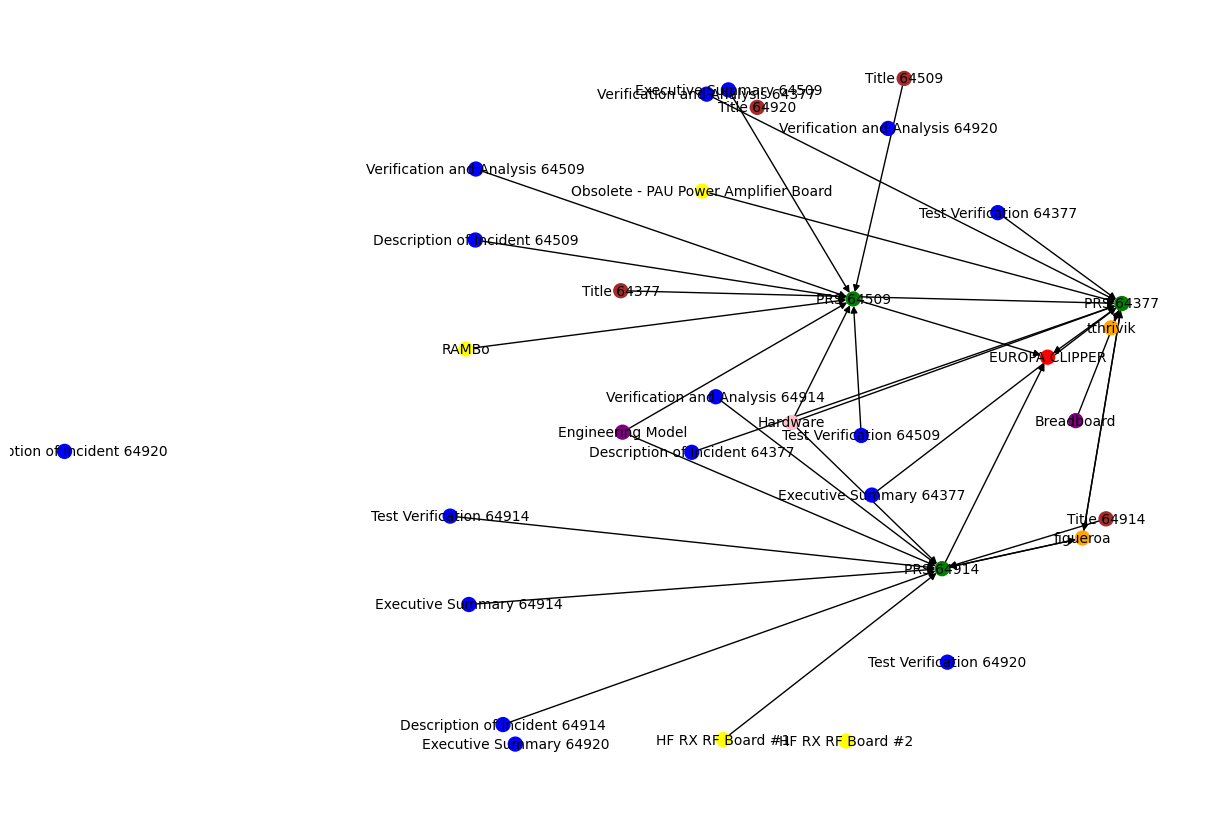

In [11]:
#--------------------------GENERATE NETWORKX GRAPH VISUALIZATION-----------------
import networkx as nx
import matplotlib.pyplot as plt

# Convert DGL graph to NetworkX graph
nx_G = test_subgraph.to_networkx()

plt.figure(figsize=(12, 8))
# Visualize the NetworkX graph
pos = nx.spring_layout(nx_G,k=0.7,scale=3)  # Layout algorithm (e.g., spring_layout, circular_layout, etc.)
nx.draw(nx_G, pos, with_labels=False,node_size=100,node_color = test_color_map)#True,labels=label_dictionary,font_size=8)
# Draw node labels with custom font size
nx.draw_networkx_labels(nx_G, pos, labels=test_label_map, font_size=10)

plt.savefig("graph_image.png", dpi=300)
plt.show()

In [12]:
import numpy as np

# same negative edges from adjancency matrix
def sample_negative_edges(adj, num):
        neg_u, neg_v = adj.nonzero()
        selection = np.arange(len(neg_u))
        selection = np.random.permutation(selection)
        selection = selection[:num]
        
        neg_u = list(neg_u[selection])
        neg_v = list(neg_v[selection])
        
        return neg_u, neg_v

In [13]:
def remove_para_doc_edges_by_subsys(adj):
    for i in range(len(adj)):
        for j in range(len(adj[0])):
            if adj[i][j]==1:
                if node_dictionary[label_dictionary[j]]['Subsystem Item'] == node_dictionary['PRS '+str(node_dictionary[label_dictionary[i]]['parent_prs'])]['Subsystem Item']:
                    adj[i][j]=0

    return adj

In [14]:
def remove_para_doc_edges_by_prob_area(adj):
    for i in range(len(adj)):
        for j in range(len(adj[0])):
            if adj[i][j]==1:
                if node_dictionary[label_dictionary[j]]['Suspected Problem Area'] == node_dictionary['PRS '+str(node_dictionary[label_dictionary[i]]['parent_prs'])]['Suspected Problem Area']:
                    adj[i][j]=0

    return adj

In [15]:
#-------------CODE TO GENERATE LISTS OF THE ID'S OF EACH TYPE OF NODE---------------

para_nodes_id_list = [i for i in range(len(dataset.G.ndata['label'])) if dataset.G.ndata['label'][i]==torch.tensor([0])]
para_nodes_id_list.pop() #to get rid of inference node
doc_nodes_id_list = [i for i in range(len(dataset.G.ndata['label'])) if dataset.G.ndata['label'][i]==torch.tensor([1])]
proj_nodes_id_list = [i for i in range(len(dataset.G.ndata['label'])) if dataset.G.ndata['label'][i]==torch.tensor([2])]
title_nodes_id_list = [i for i in range(len(dataset.G.ndata['label'])) if dataset.G.ndata['label'][i]==torch.tensor([3])]
subsys_nodes_id_list = [i for i in range(len(dataset.G.ndata['label'])) if dataset.G.ndata['label'][i]==torch.tensor([4])]
prob_area_nodes_id_list = [i for i in range(len(dataset.G.ndata['label'])) if dataset.G.ndata['label'][i]==torch.tensor([5])]
prob_type_nodes_id_list = [i for i in range(len(dataset.G.ndata['label'])) if dataset.G.ndata['label'][i]==torch.tensor([6])]
author_nodes_id_list = [i for i in range(len(dataset.G.ndata['label'])) if dataset.G.ndata['label'][i]==torch.tensor([7])]

In [16]:
def generate_train_test_edges(test_size=0.05, neg_ratio=1, test_method=0):
    u, v = dataset.G.edges()
    all_u, all_v = dataset.G.edges()
    
    u = torch.hstack((u,u,u))
    v = torch.hstack((v,v,v))
    
    eids = np.arange(dataset.G.number_of_edges())
    eids = np.random.permutation(eids)
    test_size = int(len(eids) * test_size)
    train_size = dataset.G.number_of_edges() - test_size

    num_test_size=test_size
    num_train_size=train_size
    
    df = pd.read_csv('author_dataset_europa_smap.csv')
    df = df.drop_duplicates()
    df = df[df.group!='na']

    edge_df = pd.DataFrame({'u': u.numpy(), 'v':v.numpy()})
    
    neg_u, neg_v = [], []
    while len(neg_u) < u.shape[0]*0.5: #50% contrastive sampling by group
        group1, group2 = random.sample(list(df.group.unique()), 2)
        group1_anomalies = list(df[df.group==group1].anomaly_id.values)
        group2_anomalies = list(df[df.group==group2].anomaly_id.values)
        g1a_sample = int(random.choice(group1_anomalies).split('_')[-2])
        g2a_sample = int(random.choice(group2_anomalies).split('_')[-2])

        prs1_nd_key = 'PRS ' + str(g1a_sample)
        prs1_node_id = node_dictionary[prs1_nd_key]['node_id']
        prs2_nd_key = 'PRS ' + str(g2a_sample)
        prs2_node_id = node_dictionary[prs2_nd_key]['node_id']

        if node_dictionary[prs1_nd_key]['Subsystem Item'] == node_dictionary[prs2_nd_key]['Subsystem Item'] or node_dictionary[prs1_nd_key]['Suspected Problem Area'] == node_dictionary[prs2_nd_key]['Suspected Problem Area']:
            continue

        prs1_inc_edges = edge_df[edge_df.v==prs1_node_id].u.values

        s_u = random.choice(prs1_inc_edges)
        s_v = prs2_node_id
        neg_u.append(s_u)
        neg_v.append(s_v)

    #---------------paragraph->document 25% contrastive sampling subsystem + problem area----------------------------
    adj = np.zeros((dataset.G.num_nodes()-1, dataset.G.num_nodes()-1))
    for u_ind,v_ind in zip(u,v): adj[u_ind, v_ind] = 1
    adj_neg = 1 - adj - np.eye(dataset.G.number_of_nodes()-1)

    # random_u=[] #remove if going back to v1
    # random_v=[]

    #paragraph-document negative edges
    num_edges = min((dataset.G.edata['label']==dataset.edge_types['PARA_DOC']).sum().item(),u.shape[0]*0.25)
    # num_edges = (dataset.G.edata['label']==dataset.edge_types['PARA_DOC']).sum().item()
    mask1, mask2 = np.zeros(adj_neg.shape), np.zeros(adj_neg.shape)
    mask1[para_nodes_id_list, :] = 1
    mask2[:, doc_nodes_id_list] = 1
    mask = mask1 * mask2
    
    adj_neg = remove_para_doc_edges_by_subsys(adj_neg*mask)
    adj_neg = remove_para_doc_edges_by_prob_area(adj_neg)

    n_u, n_v = sample_negative_edges(adj_neg, num_edges*neg_ratio) #need to change num_edges*neg_ratio
    neg_u += n_u
    neg_v += n_v
    # random_u += n_u
    # random_v += n_v 

    #--------------------------random sampling 25%-------------------------------
    random_u=[]
    random_v=[]

    #document-project negative edges
    num_edges = (dataset.G.edata['label']==dataset.edge_types['DOC_PROJ']).sum().item()
    mask1, mask2 = np.zeros(adj_neg.shape), np.zeros(adj_neg.shape)
    mask1[doc_nodes_id_list, :] = 1
    mask2[:, proj_nodes_id_list] = 1
    mask = mask1 * mask2
        
    n_u, n_v = sample_negative_edges(adj_neg*mask, num_edges*neg_ratio)
    random_u += n_u
    random_v += n_v 

    # #document-author negative edges
    # num_edges = (dataset.G.edata['label']==dataset.edge_types['DOC_AUTHOR']).sum().item()
    # mask1, mask2 = np.zeros(adj_neg.shape), np.zeros(adj_neg.shape)
    # mask1[doc_nodes_id_list, :] = 1
    # mask2[:, author_nodes_id_list] = 1
    # mask = mask1 * mask2
        
    # n_u, n_v = sample_negative_edges(adj_neg*mask, num_edges*neg_ratio)
    # random_u += n_u
    # random_v += n_v 

    # #author-document negative edges
    # num_edges = (dataset.G.edata['label']==dataset.edge_types['AUTHOR_DOC']).sum().item()
    # mask1, mask2 = np.zeros(adj_neg.shape), np.zeros(adj_neg.shape)
    # mask1[author_nodes_id_list, :] = 1
    # mask2[:, doc_nodes_id_list] = 1
    # mask = mask1 * mask2
        
    # n_u, n_v = sample_negative_edges(adj_neg*mask, num_edges*neg_ratio)
    # random_u += n_u
    # random_v += n_v

    #title-document negative edges
    num_edges = (dataset.G.edata['label']==dataset.edge_types['TITLE_DOC']).sum().item()
    mask1, mask2 = np.zeros(adj_neg.shape), np.zeros(adj_neg.shape)
    mask1[title_nodes_id_list, :] = 1
    mask2[:, doc_nodes_id_list] = 1
    mask = mask1 * mask2
        
    n_u, n_v = sample_negative_edges(adj_neg*mask, num_edges*neg_ratio)
    random_u += n_u
    random_v += n_v

    #subsystem-document negative edges
    num_edges = (dataset.G.edata['label']==dataset.edge_types['SUBSYSTEM_DOC']).sum().item()
    mask1, mask2 = np.zeros(adj_neg.shape), np.zeros(adj_neg.shape)
    mask1[subsys_nodes_id_list, :] = 1
    mask2[:, doc_nodes_id_list] = 1
    mask = mask1 * mask2
        
    n_u, n_v = sample_negative_edges(adj_neg*mask, num_edges*neg_ratio)
    random_u += n_u
    random_v += n_v 

    #prob area-document negative edges
    num_edges = (dataset.G.edata['label']==dataset.edge_types['PROB_AREA_DOC']).sum().item()
    mask1, mask2 = np.zeros(adj_neg.shape), np.zeros(adj_neg.shape)
    mask1[prob_area_nodes_id_list, :] = 1
    mask2[:, doc_nodes_id_list] = 1
    mask = mask1 * mask2
        
    n_u, n_v = sample_negative_edges(adj_neg*mask, num_edges*neg_ratio)
    random_u += n_u
    random_v += n_v 

   #prob type-document negative edges
    num_edges = (dataset.G.edata['label']==dataset.edge_types['PROB_TYPE_DOC']).sum().item()
    mask1, mask2 = np.zeros(adj_neg.shape), np.zeros(adj_neg.shape)
    mask1[prob_type_nodes_id_list, :] = 1
    mask2[:, doc_nodes_id_list] = 1
    mask = mask1 * mask2
        
    n_u, n_v = sample_negative_edges(adj_neg*mask, num_edges*neg_ratio)
    random_u += n_u
    random_v += n_v

    #select 25% of u size from random vertices set
    selection = np.arange(len(random_u))
    selection = np.random.permutation(selection)
    selection = selection[:int(u.shape[0]*0.25)]   
    select_u = list(np.array(random_u)[selection])
    select_v = list(np.array(random_v)[selection])

    neg_u += select_u
    neg_v += select_v

    #-----------------------------------------------------------

    print('NEGU: ',neg_u)
    print('NEGV: ',neg_v)
    print(len(neg_u))

    neg_edge_e_list_len=len(neg_u)

    #-------------------------------
    #generate training and testing edges

    if test_method==0:
        train_e_idxs = eids[test_size:]
        test_e_idxs = eids[:test_size]

        test_pos_u, test_pos_v = u[eids[:test_size]], v[eids[:test_size]]
        train_pos_u, train_pos_v = u[eids[test_size:]], v[eids[test_size:]]

        test_neg_u, test_neg_v = neg_u[:test_size], neg_v[:test_size]
        train_neg_u, train_neg_v = neg_u[test_size:], neg_v[test_size:]

        pos_test_size=len(eids[:test_size])
        pos_train_size=len(eids[test_size:])
        neg_test_size=len(neg_u[:test_size])
        neg_train_size=len(neg_u[test_size:])
    
        # This graph connectivity is used for message passing
        train_g = dgl.remove_edges(dataset.G, eids[:test_size])

         # These graphs tell MLPPredictor which edges to predict the probability of existing
        train_pos_g = dgl.graph((train_pos_u, train_pos_v), num_nodes=dataset.G.number_of_nodes())
        train_neg_g = dgl.graph((train_neg_u, train_neg_v), num_nodes=dataset.G.number_of_nodes())

    if test_method == 0:
        test_pos_g = dgl.graph((test_pos_u, test_pos_v), num_nodes=dataset.G.number_of_nodes())
        test_neg_g = dgl.graph((test_neg_u, test_neg_v), num_nodes=dataset.G.number_of_nodes())

    # for i in range(len(train_pos_u)):
    #     print(train_pos_u[i],'->',train_pos_v[i])

    return train_g, train_pos_g, train_neg_g, train_e_idxs, test_pos_g, test_neg_g, test_e_idxs, neg_edge_e_list_len, num_test_size, num_train_size, pos_test_size, pos_train_size, neg_test_size, neg_train_size

#comment out    
# train_g, train_pos_g, train_neg_g, train_e_idxs, test_pos_g, test_neg_g, test_e_idxs, neg_edge_e_list_len, num_test_size, num_train_size, pos_test_size, pos_train_size, neg_test_size, neg_train_size = generate_train_test_edges()
# torch.save(train_e_idxs,'train_e_idxs.pt')
# torch.save(test_e_idxs,'test_e_idxs.pt')

In [16]:
# def generate_train_test_edges(test_size=0.05, neg_ratio=1, test_method=0):
#     u, v = dataset.G.edges()
#     all_u, all_v = dataset.G.edges()
    
#     u = torch.hstack((u,u,u))
#     v = torch.hstack((v,v,v))
    
#     eids = np.arange(dataset.G.number_of_edges())
#     eids = np.random.permutation(eids)
#     test_size = int(len(eids) * test_size)
#     train_size = dataset.G.number_of_edges() - test_size

#     num_test_size=test_size
#     num_train_size=train_size
    
#     df = pd.read_csv('author_dataset_europa_smap.csv')
#     df = df.drop_duplicates()
#     df = df[df.group!='na']

#     edge_df = pd.DataFrame({'u': u.numpy(), 'v':v.numpy()})
    
#     neg_u, neg_v = [], []
#     while len(neg_u) < all_u.shape[0]:
#         group1, group2 = random.sample(list(df.group.unique()), 2)
#         group1_anomalies = list(df[df.group==group1].anomaly_id.values)
#         group2_anomalies = list(df[df.group==group2].anomaly_id.values)
#         g1a_sample = int(random.choice(group1_anomalies).split('_')[-2])
#         g2a_sample = int(random.choice(group2_anomalies).split('_')[-2])

#         prs1_nd_key = 'PRS ' + str(g1a_sample)
#         prs1_node_id = node_dictionary[prs1_nd_key]['node_id']
#         prs2_nd_key = 'PRS ' + str(g2a_sample)
#         prs2_node_id = node_dictionary[prs2_nd_key]['node_id']

#         if node_dictionary[prs1_nd_key]['Subsystem Item'] == node_dictionary[prs2_nd_key]['Subsystem Item'] or node_dictionary[prs1_nd_key]['Suspected Problem Area'] == node_dictionary[prs2_nd_key]['Suspected Problem Area']:
#             continue

#         prs1_inc_edges = edge_df[edge_df.v==prs1_node_id].u.values

#         s_u = random.choice(prs1_inc_edges)
#         s_v = prs2_node_id
#         neg_u.append(s_u)
#         neg_v.append(s_v)

#     print('NEGU: ',neg_u)
#     print('NEGV: ',neg_v)
#     print(len(neg_u))

#     neg_edge_e_list_len=len(neg_u)

#     #-------------------------------
#     #generate training and testing edges

#     if test_method==0:
#         train_e_idxs = eids[test_size:]
#         test_e_idxs = eids[:test_size]

#         test_pos_u, test_pos_v = u[eids[:test_size]], v[eids[:test_size]]
#         train_pos_u, train_pos_v = u[eids[test_size:]], v[eids[test_size:]]

#         test_neg_u, test_neg_v = neg_u[:test_size], neg_v[:test_size]
#         train_neg_u, train_neg_v = neg_u[test_size:], neg_v[test_size:]

#         pos_test_size=len(eids[:test_size])
#         pos_train_size=len(eids[test_size:])
#         neg_test_size=len(neg_u[:test_size])
#         neg_train_size=len(neg_u[test_size:])
    
#         # This graph connectivity is used for message passing
#         train_g = dgl.remove_edges(dataset.G, eids[:test_size])

#          # These graphs tell MLPPredictor which edges to predict the probability of existing
#         train_pos_g = dgl.graph((train_pos_u, train_pos_v), num_nodes=dataset.G.number_of_nodes())
#         train_neg_g = dgl.graph((train_neg_u, train_neg_v), num_nodes=dataset.G.number_of_nodes())

#     if test_method == 0:
#         test_pos_g = dgl.graph((test_pos_u, test_pos_v), num_nodes=dataset.G.number_of_nodes())
#         test_neg_g = dgl.graph((test_neg_u, test_neg_v), num_nodes=dataset.G.number_of_nodes())

#     # for i in range(len(train_pos_u)):
#     #     print(train_pos_u[i],'->',train_pos_v[i])

#     return train_g, train_pos_g, train_neg_g, train_e_idxs, test_pos_g, test_neg_g, test_e_idxs, neg_edge_e_list_len, num_test_size, num_train_size, pos_test_size, pos_train_size, neg_test_size, neg_train_size
            
# train_g, train_pos_g, train_neg_g, train_e_idxs, test_pos_g, test_neg_g, test_e_idxs, neg_edge_e_list_len, num_test_size, num_train_size, pos_test_size, pos_train_size, neg_test_size, neg_train_size = generate_train_test_edges()
# torch.save(train_e_idxs,'train_e_idxs.pt')
# torch.save(test_e_idxs,'test_e_idxs.pt')

In [17]:
# # generate training and testing edges for positive and negative graphs

# def generate_train_test_edges(test_size=0.05, neg_ratio=1, test_method=0):
#     u, v = dataset.G.edges()

#     #--------------
#     u = torch.hstack((u,u,u))
#     v = torch.hstack((v,v,v))
#     #--------------

#     eids = np.arange(dataset.G.number_of_edges())
#     eids = np.random.permutation(eids)
#     test_size = int(len(eids) * test_size)
#     train_size = dataset.G.number_of_edges() - test_size

#     num_test_size=test_size
#     num_train_size=train_size

#     adj = np.zeros((dataset.G.num_nodes(), dataset.G.num_nodes()))
#     for u_ind,v_ind in zip(u,v): adj[u_ind, v_ind] = 1
#     adj_neg = 1 - adj - np.eye(dataset.G.number_of_nodes())

#     # ----Generate negative edges----
#     # Create negative edges in proportion to edge types that exist in graph
#     neg_u, neg_v = [], []


#     #paragraph-document negative edges
#     num_edges = (dataset.G.edata['label']==dataset.edge_types['PARA_DOC']).sum().item()
#     mask1, mask2 = np.zeros(adj_neg.shape), np.zeros(adj_neg.shape)
#     mask1[para_nodes_id_list, :] = 1
#     mask2[:, doc_nodes_id_list] = 1
#     mask = mask1 * mask2
    
#     adj_neg = remove_para_doc_edges_by_subsys(adj_neg*mask)
#     adj_neg = remove_para_doc_edges_by_prob_area(adj_neg)
#     adj_neg = remove_para_doc_edges_by_author_group(adj_neg)

#     n_u, n_v = sample_negative_edges(adj_neg, num_edges*neg_ratio)
#     neg_u += n_u
#     neg_v += n_v 

#     #document-project negative edges
#     num_edges = (dataset.G.edata['label']==dataset.edge_types['DOC_PROJ']).sum().item()
#     mask1, mask2 = np.zeros(adj_neg.shape), np.zeros(adj_neg.shape)
#     mask1[doc_nodes_id_list, :] = 1
#     mask2[:, proj_nodes_id_list] = 1
#     mask = mask1 * mask2
        
#     n_u, n_v = sample_negative_edges(adj_neg*mask, num_edges*neg_ratio)
#     neg_u += n_u
#     neg_v += n_v 

#     #----------CODE TO GENERATE AUTHOR<-> DOCUMENT NEGATIVE EDGES-----------------
#     #document-author negative edges
#     num_edges = (dataset.G.edata['label']==dataset.edge_types['DOC_AUTHOR']).sum().item()
#     mask1, mask2 = np.zeros(adj_neg.shape), np.zeros(adj_neg.shape)
#     mask1[doc_nodes_id_list, :] = 1
#     mask2[:, author_nodes_id_list] = 1
#     mask = mask1 * mask2
        
#     n_u, n_v = sample_negative_edges(adj_neg*mask, num_edges*neg_ratio)
#     neg_u += n_u
#     neg_v += n_v 

#     #author-document negative edges
#     num_edges = (dataset.G.edata['label']==dataset.edge_types['AUTHOR_DOC']).sum().item()
#     mask1, mask2 = np.zeros(adj_neg.shape), np.zeros(adj_neg.shape)
#     mask1[author_nodes_id_list, :] = 1
#     mask2[:, doc_nodes_id_list] = 1
#     mask = mask1 * mask2
        
#     n_u, n_v = sample_negative_edges(adj_neg*mask, num_edges*neg_ratio)
#     neg_u += n_u
#     neg_v += n_v 
#     #-------------------------------------------------------------------

#     #title-document negative edges
#     num_edges = (dataset.G.edata['label']==dataset.edge_types['TITLE_DOC']).sum().item()
#     mask1, mask2 = np.zeros(adj_neg.shape), np.zeros(adj_neg.shape)
#     mask1[title_nodes_id_list, :] = 1
#     mask2[:, doc_nodes_id_list] = 1
#     mask = mask1 * mask2
        
#     n_u, n_v = sample_negative_edges(adj_neg*mask, num_edges*neg_ratio)
#     neg_u += n_u
#     neg_v += n_v 

#     #subsystem-document negative edges
#     num_edges = (dataset.G.edata['label']==dataset.edge_types['SUBSYSTEM_DOC']).sum().item()
#     mask1, mask2 = np.zeros(adj_neg.shape), np.zeros(adj_neg.shape)
#     mask1[subsys_nodes_id_list, :] = 1
#     mask2[:, doc_nodes_id_list] = 1
#     mask = mask1 * mask2
        
#     n_u, n_v = sample_negative_edges(adj_neg*mask, num_edges*neg_ratio)
#     neg_u += n_u
#     neg_v += n_v 

#     #prob area-document negative edges
#     num_edges = (dataset.G.edata['label']==dataset.edge_types['PROB_AREA_DOC']).sum().item()
#     mask1, mask2 = np.zeros(adj_neg.shape), np.zeros(adj_neg.shape)
#     mask1[prob_area_nodes_id_list, :] = 1
#     mask2[:, doc_nodes_id_list] = 1
#     mask = mask1 * mask2
        
#     n_u, n_v = sample_negative_edges(adj_neg*mask, num_edges*neg_ratio)
#     neg_u += n_u
#     neg_v += n_v 

#    #prob type-document negative edges
#     num_edges = (dataset.G.edata['label']==dataset.edge_types['PROB_TYPE_DOC']).sum().item()
#     mask1, mask2 = np.zeros(adj_neg.shape), np.zeros(adj_neg.shape)
#     mask1[prob_type_nodes_id_list, :] = 1
#     mask2[:, doc_nodes_id_list] = 1
#     mask = mask1 * mask2
        
#     n_u, n_v = sample_negative_edges(adj_neg*mask, num_edges*neg_ratio)
#     neg_u += n_u
#     neg_v += n_v 

#     print('NEGU: ',neg_u)
#     print('NEGV: ',neg_v)

#     neg_edge_e_list_len=len(neg_u)

#     #-------------------------------
#     #generate training and testing edges

#     if test_method==0:
#         train_e_idxs = eids[test_size:]
#         test_e_idxs = eids[:test_size]

#         test_pos_u, test_pos_v = u[eids[:test_size]], v[eids[:test_size]]
#         train_pos_u, train_pos_v = u[eids[test_size:]], v[eids[test_size:]]

#         test_neg_u, test_neg_v = neg_u[:test_size], neg_v[:test_size]
#         train_neg_u, train_neg_v = neg_u[test_size:], neg_v[test_size:]

#         pos_test_size=len(eids[:test_size])
#         pos_train_size=len(eids[test_size:])
#         neg_test_size=len(neg_u[:test_size])
#         neg_train_size=len(neg_u[test_size:])
    
#         # This graph connectivity is used for message passing
#         train_g = dgl.remove_edges(dataset.G, eids[:test_size])

#          # These graphs tell MLPPredictor which edges to predict the probability of existing
#         train_pos_g = dgl.graph((train_pos_u, train_pos_v), num_nodes=dataset.G.number_of_nodes())
#         train_neg_g = dgl.graph((train_neg_u, train_neg_v), num_nodes=dataset.G.number_of_nodes())

#     if test_method == 0:
#         test_pos_g = dgl.graph((test_pos_u, test_pos_v), num_nodes=dataset.G.number_of_nodes())
#         test_neg_g = dgl.graph((test_neg_u, test_neg_v), num_nodes=dataset.G.number_of_nodes())

#     # for i in range(len(train_pos_u)):
#     #     print(train_pos_u[i],'->',train_pos_v[i])

#     return train_g, train_pos_g, train_neg_g, train_e_idxs, test_pos_g, test_neg_g, test_e_idxs, neg_edge_e_list_len, num_test_size, num_train_size, pos_test_size, pos_train_size, neg_test_size, neg_train_size
            
# train_g, train_pos_g, train_neg_g, train_e_idxs, test_pos_g, test_neg_g, test_e_idxs, neg_edge_e_list_len, num_test_size, num_train_size, pos_test_size, pos_train_size, neg_test_size, neg_train_size = generate_train_test_edges()


In [18]:
# print sizes of each data split
# print(neg_edge_e_list_len)
# print(num_test_size)
# print(num_train_size)
# print(pos_test_size)
# print(pos_train_size)
# print(neg_test_size)
# print(neg_train_size)
# print(dataset.G.edata['label'][train_e_idxs])
# print(dataset.G.edata['label'][test_e_idxs])

In [17]:
# heatmap setup code

edge_id_to_label_dict = {0:'PARA_DOC', 1:'DOC_PROJ',2:'TITLE_DOC',3:'SUBSYSTEM_DOC',4:'PROB_AREA_DOC',5:'PROB_TYPE_DOC',6:'DOC_AUTHOR',7:'AUTHOR_DOC',8:'NEG_EDGE'}

train_edge_classification_dict = {
    0: {'PARA_DOC': 0, 'DOC_PROJ': 0, 'TITLE_DOC':0, 'SUBSYSTEM_DOC':0, 'PROB_AREA_DOC':0, 'PROB_TYPE_DOC':0, 'DOC_AUTHOR':0, 'AUTHOR_DOC':0, 'NEG_EDGE':0},
    1: {'PARA_DOC': 0, 'DOC_PROJ': 0, 'TITLE_DOC':0, 'SUBSYSTEM_DOC':0, 'PROB_AREA_DOC':0, 'PROB_TYPE_DOC':0, 'DOC_AUTHOR':0, 'AUTHOR_DOC':0, 'NEG_EDGE':0},
    2: {'PARA_DOC': 0, 'DOC_PROJ': 0, 'TITLE_DOC':0, 'SUBSYSTEM_DOC':0, 'PROB_AREA_DOC':0, 'PROB_TYPE_DOC':0, 'DOC_AUTHOR':0, 'AUTHOR_DOC':0, 'NEG_EDGE':0},
    3: {'PARA_DOC': 0, 'DOC_PROJ': 0, 'TITLE_DOC':0, 'SUBSYSTEM_DOC':0, 'PROB_AREA_DOC':0, 'PROB_TYPE_DOC':0, 'DOC_AUTHOR':0, 'AUTHOR_DOC':0, 'NEG_EDGE':0},
    4: {'PARA_DOC': 0, 'DOC_PROJ': 0, 'TITLE_DOC':0, 'SUBSYSTEM_DOC':0, 'PROB_AREA_DOC':0, 'PROB_TYPE_DOC':0, 'DOC_AUTHOR':0, 'AUTHOR_DOC':0, 'NEG_EDGE':0},
    5: {'PARA_DOC': 0, 'DOC_PROJ': 0, 'TITLE_DOC':0, 'SUBSYSTEM_DOC':0, 'PROB_AREA_DOC':0, 'PROB_TYPE_DOC':0, 'DOC_AUTHOR':0, 'AUTHOR_DOC':0, 'NEG_EDGE':0},
    6: {'PARA_DOC': 0, 'DOC_PROJ': 0, 'TITLE_DOC':0, 'SUBSYSTEM_DOC':0, 'PROB_AREA_DOC':0, 'PROB_TYPE_DOC':0, 'DOC_AUTHOR':0, 'AUTHOR_DOC':0, 'NEG_EDGE':0},
    7: {'PARA_DOC': 0, 'DOC_PROJ': 0, 'TITLE_DOC':0, 'SUBSYSTEM_DOC':0, 'PROB_AREA_DOC':0, 'PROB_TYPE_DOC':0, 'DOC_AUTHOR':0, 'AUTHOR_DOC':0, 'NEG_EDGE':0},
    8: {'PARA_DOC': 0, 'DOC_PROJ': 0, 'TITLE_DOC':0, 'SUBSYSTEM_DOC':0, 'PROB_AREA_DOC':0, 'PROB_TYPE_DOC':0, 'DOC_AUTHOR':0, 'AUTHOR_DOC':0, 'NEG_EDGE':0}

}

test_edge_classification_dict = {
    0: {'PARA_DOC': 0, 'DOC_PROJ': 0, 'TITLE_DOC':0, 'SUBSYSTEM_DOC':0, 'PROB_AREA_DOC':0, 'PROB_TYPE_DOC':0, 'DOC_AUTHOR':0, 'AUTHOR_DOC':0, 'NEG_EDGE':0},
    1: {'PARA_DOC': 0, 'DOC_PROJ': 0, 'TITLE_DOC':0, 'SUBSYSTEM_DOC':0, 'PROB_AREA_DOC':0, 'PROB_TYPE_DOC':0, 'DOC_AUTHOR':0, 'AUTHOR_DOC':0, 'NEG_EDGE':0},
    2: {'PARA_DOC': 0, 'DOC_PROJ': 0, 'TITLE_DOC':0, 'SUBSYSTEM_DOC':0, 'PROB_AREA_DOC':0, 'PROB_TYPE_DOC':0, 'DOC_AUTHOR':0, 'AUTHOR_DOC':0, 'NEG_EDGE':0},
    3: {'PARA_DOC': 0, 'DOC_PROJ': 0, 'TITLE_DOC':0, 'SUBSYSTEM_DOC':0, 'PROB_AREA_DOC':0, 'PROB_TYPE_DOC':0, 'DOC_AUTHOR':0, 'AUTHOR_DOC':0, 'NEG_EDGE':0},
    4: {'PARA_DOC': 0, 'DOC_PROJ': 0, 'TITLE_DOC':0, 'SUBSYSTEM_DOC':0, 'PROB_AREA_DOC':0, 'PROB_TYPE_DOC':0, 'DOC_AUTHOR':0, 'AUTHOR_DOC':0, 'NEG_EDGE':0},
    5: {'PARA_DOC': 0, 'DOC_PROJ': 0, 'TITLE_DOC':0, 'SUBSYSTEM_DOC':0, 'PROB_AREA_DOC':0, 'PROB_TYPE_DOC':0, 'DOC_AUTHOR':0, 'AUTHOR_DOC':0, 'NEG_EDGE':0},
    6: {'PARA_DOC': 0, 'DOC_PROJ': 0, 'TITLE_DOC':0, 'SUBSYSTEM_DOC':0, 'PROB_AREA_DOC':0, 'PROB_TYPE_DOC':0, 'DOC_AUTHOR':0, 'AUTHOR_DOC':0, 'NEG_EDGE':0},
    7: {'PARA_DOC': 0, 'DOC_PROJ': 0, 'TITLE_DOC':0, 'SUBSYSTEM_DOC':0, 'PROB_AREA_DOC':0, 'PROB_TYPE_DOC':0, 'DOC_AUTHOR':0, 'AUTHOR_DOC':0, 'NEG_EDGE':0},
    8: {'PARA_DOC': 0, 'DOC_PROJ': 0, 'TITLE_DOC':0, 'SUBSYSTEM_DOC':0, 'PROB_AREA_DOC':0, 'PROB_TYPE_DOC':0, 'DOC_AUTHOR':0, 'AUTHOR_DOC':0, 'NEG_EDGE':0}

}

train_e_list=[]
test_e_list=[]

In [18]:
# compute accuracy of model output versus true labels
# record edge classifications during epoch 1950

def compute_accuracy(out, lbs, epoch, mode):
    matches = 0
    total = len(lbs)
    softmax_outputs = torch.nn.Softmax()(out)
    
    for i in range(total):

        if softmax_outputs[i][lbs[i]] > 0.5: 
            matches += 1

            if epoch==1950:
                true_label = lbs[i].item()
                if mode=='train':
                    train_edge_classification_dict[true_label][edge_id_to_label_dict[true_label]]+=1
                    train_e_list.append(True)
                else:
                    test_edge_classification_dict[true_label][edge_id_to_label_dict[true_label]]+=1
                    test_e_list.append(True)

        elif epoch==1950 and softmax_outputs[i][lbs[i]] <= 0.5:
            true_label = lbs[i].item()
            false_label = torch.argmax(softmax_outputs[i]).item()
            if mode=='train':
                train_edge_classification_dict[true_label][edge_id_to_label_dict[false_label]]+=1
                train_e_list.append(False)
            else:
                test_edge_classification_dict[true_label][edge_id_to_label_dict[false_label]]+=1
                test_e_list.append(False)

    return matches/total


In [19]:
#-----------GraphSAGE model------------------

# build a two-layer GraphSAGE model
class GraphSAGE(nn.Module):
    def __init__(self, in_feats, h_feats, drop=0.5):
        super(GraphSAGE, self).__init__()
        
        self.mlp = nn.Sequential(nn.Linear(in_feats, int(in_feats/2)),
                                 nn.Dropout(drop),
                                 nn.ReLU(),
                                 nn.Linear(int(in_feats/2), int(in_feats/4)),
                                 nn.Dropout(drop),
                                 nn.ReLU(),
                                 nn.Linear(int(in_feats/4), int(128)),
                                 nn.Dropout(drop),
                                 nn.ReLU())
        self.conv1 = SAGEConv(int(128), h_feats, 'mean', feat_drop=drop)
        self.conv2 = SAGEConv(h_feats, h_feats, 'mean', feat_drop=drop)
        self.conv3 = SAGEConv(h_feats, h_feats, 'mean', feat_drop=drop)

    def forward(self, g, in_feat, e_feat):
        # Flatten Features then run a linear model on them
        x = in_feat.view(in_feat.shape[0], -1)
        x = self.mlp(x)
        
        # Used transformed features in GNN
        h = self.conv1(g, x, e_feat)
        h = F.relu(h)
        h = self.conv2(g, h, e_feat)
        h = F.relu(h)
        h = self.conv3(g, h, e_feat)
        return h
    
class DotPredictor(nn.Module):
    def forward(self, g, h):
        with g.local_scope():
            g.ndata['h'] = h
            # Compute a new edge feature named 'score' by a dot-product between the
            # source node feature 'h' and destination node feature 'h'.
            g.apply_edges(fn.u_dot_v('h', 'h', 'score'))
            # u_dot_v returns a 1-element vector for each edge so you need to squeeze it.
            return g.edata['score'][:, 0]
        
class MLPPredictor(nn.Module):
    def __init__(self, h_feats, out_feats):
        super().__init__()
        self.W1 = nn.Linear(h_feats * 2, h_feats)
        self.W2 = nn.Linear(h_feats, int(h_feats/2))
        self.W3 = nn.Linear(int(h_feats/2), out_feats)
        
        self.W4 = nn.Linear(int(h_feats/2), int(h_feats/4))
        self.W5 = nn.Linear(int(h_feats/4), 1)
        self.W6 = nn.Linear(int(h_feats/4), out_feats)
        
        self.model_edge = nn.Sequential(self.W1,
                                        nn.ReLU(),
                                        self.W2,
                                        nn.ReLU(),
                                        self.W4,
                                        nn.ReLU(),
                                        self.W6)
        
        self.model_subgraph = nn.Sequential(self.W1,
                                            nn.ReLU(),
                                            self.W2,
                                            nn.ReLU(),
                                            self.W4,
                                            nn.ReLU(),
                                            self.W5)
                                        
                                        

    def apply_edges(self, edges):
        """
        Computes a scalar score for each edge of the given graph.

        Parameters
        ----------
        edges :
            Has three members ``src``, ``dst`` and ``data``, each of
            which is a dictionary representing the features of the
            source nodes, the destination nodes, and the edges
            themselves.

        Returns
        -------
        dict
            A dictionary of new edge features.
        """
        h = torch.cat([edges.src['h'], edges.dst['h']], 1)
        
        embedding = F.relu(self.W2(F.relu(self.W1(h))))
        edge_score = self.model_edge(h)
        subgraph_score = self.model_subgraph(h)
        return {'score': edge_score.squeeze(1), 'subgraph_score': subgraph_score.squeeze(1)}

    def forward(self, g, h):
        with g.local_scope():
            g.ndata['h'] = h
            g.apply_edges(self.apply_edges)
            return g.edata['score'], g.edata['subgraph_score']


In [20]:
import itertools

#training function

def train_v3(#model,
        #   pred,
        #   optimizer,
          train_g,
          #train_features,
          #train_labels,
          #test_labels,
          train_pos_g,
          train_neg_g,
          test_pos_g,
          test_neg_g,
          train_e_idxs,
          test_e_idxs, 
          epochs=2000,
          save_name="v10_IS_neg"
         ):
    
    g=dataset.G
    
    device=torch.device('cpu')

    #----
    h_feats=128
    out_feats=9
    drop=0.25
    lr=0.002
    model = GraphSAGE(train_g.ndata['attr'].shape[-1], 
                                 h_feats, 
                                 drop=drop).to(device)
    pred = MLPPredictor(h_feats, out_feats).to(device)
    optimizer = torch.optim.Adam(itertools.chain(model.parameters(), pred.parameters()), lr=lr)
    #----


    losses = []
    test_losses = []

    accuracies = []
    test_accuracies = []

    max_test_accuracy = 0
    criterion = torch.nn.CrossEntropyLoss()
    
    labels = torch.cat([g.edata['label'][train_e_idxs], torch.tensor([max(g.edata['label'][train_e_idxs]).numpy()+1]*train_neg_g.num_edges())])
    test_labels = torch.cat([g.edata['label'][test_e_idxs], torch.tensor([max(g.edata['label'][train_e_idxs]).numpy()+1]*test_neg_g.num_edges())])
    
    for e in range(epochs):
        # forward
        h = model(train_g.to(device),
                                train_g.ndata['attr'].to(device), 
                                g.edata['label'][train_e_idxs].float().to(device))
        pos_score, _ = pred(train_pos_g.to(device), h)
        neg_score, _ = pred(train_neg_g.to(device), h)
        outputs = torch.cat([pos_score, neg_score])
        
        loss = criterion(outputs, labels.long().to(device))

        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if e % 5 == 0:
            dataset.G.edata['label'] = dataset.G.edata['label'].int()
            accuracy = compute_accuracy(outputs, labels,e,'train')
            
            losses.append(loss.item())
            accuracies.append(accuracy)
            
            if test_pos_g.num_edges() > 0:
                model.eval(), pred.eval()

                h = model(train_g.to(device),
                                train_g.ndata['attr'].to(device), 
                                g.edata['label'][train_e_idxs].float().to(device))
                test_pos_score, _ = pred(test_pos_g.to(device), h)
                test_neg_score, _ = pred(test_neg_g.to(device), h)
                test_outputs = torch.cat([test_pos_score, test_neg_score])

                test_loss = criterion(test_outputs, test_labels.long().to(device))  
                test_losses.append(test_loss.item())

                dataset.G.edata['label'] = dataset.G.edata['label'].int()
                test_accuracy = compute_accuracy(test_outputs, test_labels,e,'test')
                test_accuracies.append(test_accuracy)

                if test_accuracy > max_test_accuracy:
                    max_test_accuracy = test_accuracy
                    torch.save(model, f'saved_models/gnn_BEST_{save_name}.pt')
                    torch.save(h, f'saved_models/hidden_BEST_{save_name}.pt')
                    torch.save(pred, f'saved_models/outlayer_BEST_{save_name}.pt')

            torch.save(model, f'saved_models/gnn_{save_name}.pt')
            torch.save(h, f'saved_models/hidden_{save_name}.pt')
            torch.save(pred, f'saved_models/outlayer_{save_name}.pt')

            model.train(), pred.train()
            
        if e % 50 == 0: 
            print('Epoch {}/{}, Train loss: {}, Train accuracy: {}/1.0'.format(e+1, epochs, loss, accuracy))
            if test_pos_g.num_edges() > 0:
                print('Test loss: {}, Test accuracy: {}/1.0'.format(test_loss, test_accuracy))
            
    plt.figure(dpi=100)
    plt.title("Losses")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.ylim(0, 5)
    if test_pos_g.num_edges() > 0: plt.plot(list(range(0, len(test_losses)*5, 5)), test_losses, label="Test Loss")
    plt.plot(list(range(0, len(test_losses)*5, 5)), losses, label="Train Loss")
    plt.legend()
    # plt.savefig(f'results/loss_curves_edgeprediction.png', dpi=100)
    plt.show()

    plt.figure(dpi=100)
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.ylim(0, 1)
    if test_pos_g.num_edges() > 0: plt.plot(list(range(0, len(test_losses)*5, 5)), test_accuracies, label="Test Accuracy")
    plt.plot(list(range(0, len(test_losses)*5, 5)), accuracies, label="Train Accuracy")
    plt.legend()
    # plt.savefig(f'results/accuracy_curves_edgeprediction.png', dpi=100)
    plt.show()

    torch.save(train_g,f'saved_models/train_g_after_training_{save_name}.pt') #add model number

# train_v3(train_g,train_pos_g,train_neg_g,test_pos_g,test_neg_g) #comment out

In [359]:
# torch.save(dataset,'prs_graph_after_training.pt')

model 6
NEGU:  [3446, 124, 789, 61, 8558, 168, 3355, 6654, 5241, 3962, 1231, 11961, 6650, 8, 11958, 7094, 15, 13409, 13100, 13005, 8787, 10876, 40, 144, 7647, 2800, 13199, 12566, 1259, 4898, 146, 2401, 6699, 73, 9303, 638, 4912, 12862, 7879, 15, 6736, 13381, 8098, 353, 5, 12567, 1617, 8, 5238, 8846, 73, 43, 40, 11174, 7093, 6896, 7367, 13052, 366, 9438, 6643, 6649, 13201, 9488, 6652, 6704, 8, 8528, 9129, 40, 8, 353, 8658, 43, 3074, 6886, 3348, 9129, 10544, 435, 124, 403, 1387, 353, 10879, 1032, 40, 294, 15, 7733, 13051, 8676, 8, 4856, 11931, 12745, 3348, 15, 12985, 5529, 5378, 36, 12076, 12767, 43, 5491, 13041, 7094, 40, 9874, 9484, 353, 8724, 9136, 69, 124, 120, 69, 40, 1949, 5877, 8, 365, 2780, 2032, 13100, 11957, 1138, 4150, 9201, 8656, 11226, 3385, 13020, 8685, 3204, 2013, 13205, 4990, 47, 6129, 5241, 11279, 10824, 12042, 13383, 10946, 1388, 7019, 8, 7726, 124, 13202, 8589, 6396, 12950, 8808, 13005, 6748, 4815, 11599, 40, 8, 8, 1132, 37, 107, 9485, 12039, 11159, 8807, 4155, 717, 8,

C:\Users\subramani\AppData\Local\Temp\ipykernel_17364\2136016036.py:7: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  softmax_outputs = torch.nn.Softmax()(out)


Epoch 1/2000, Train loss: 2.3123464584350586, Train accuracy: 0.0/1.0
Test loss: 2.154873847961426, Test accuracy: 0.0/1.0
Epoch 51/2000, Train loss: 0.867520272731781, Train accuracy: 0.6664160433491917/1.0
Test loss: 1.0828521251678467, Test accuracy: 0.5122036262203626/1.0
Epoch 101/2000, Train loss: 0.7085410952568054, Train accuracy: 0.6369634824542072/1.0
Test loss: 0.8852840662002563, Test accuracy: 0.47384937238493724/1.0
Epoch 151/2000, Train loss: 0.6386722326278687, Train accuracy: 0.6751014376272021/1.0
Test loss: 0.7844777703285217, Test accuracy: 0.47280334728033474/1.0
Epoch 201/2000, Train loss: 0.5815719366073608, Train accuracy: 0.7038280551198455/1.0
Test loss: 0.6700384616851807, Test accuracy: 0.5958856345885635/1.0
Epoch 251/2000, Train loss: 0.5570518970489502, Train accuracy: 0.6957260082187163/1.0
Test loss: 0.6812386512756348, Test accuracy: 0.646094839609484/1.0
Epoch 301/2000, Train loss: 0.4864765703678131, Train accuracy: 0.7626813238096473/1.0
Test loss: 

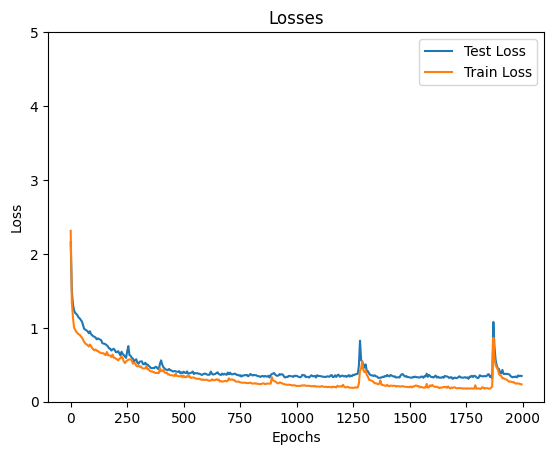

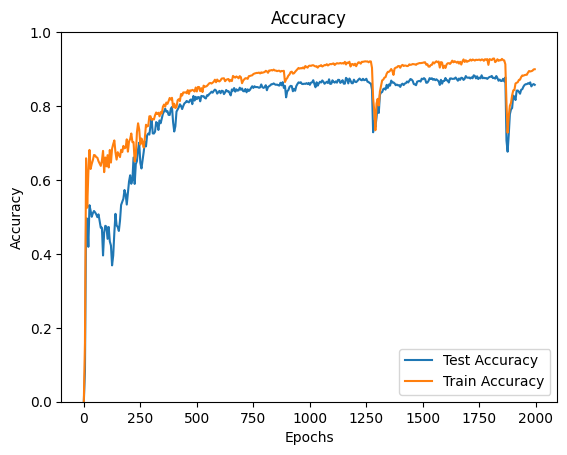

model 7
NEGU:  [3971, 9387, 10210, 13020, 6209, 5887, 3515, 124, 11885, 15, 3884, 9913, 8, 8811, 40, 7096, 61, 11826, 11188, 603, 11992, 6374, 72, 43, 6435, 9135, 603, 2861, 9217, 353, 168, 353, 353, 5825, 5897, 11720, 307, 7095, 9504, 43, 1613, 40, 11366, 3846, 168, 11957, 9365, 775, 12599, 13389, 353, 1449, 10061, 73, 10060, 10908, 11789, 738, 8816, 142, 846, 15, 10618, 12985, 603, 366, 73, 8, 124, 72, 13381, 4988, 12557, 9645, 86, 124, 2785, 13031, 37, 8673, 3348, 8377, 5471, 74, 86, 73, 12641, 8, 8079, 84, 5546, 6699, 36, 9957, 11490, 40, 365, 353, 40, 233, 13163, 13429, 37, 6088, 8065, 564, 3385, 2011, 8275, 11177, 4706, 1629, 15, 5880, 12339, 5929, 7303, 168, 43, 4150, 12985, 294, 37, 40, 1259, 13258, 68, 4133, 12615, 11686, 5068, 364, 455, 5, 43, 3310, 3385, 43, 46, 1259, 73, 3875, 11316, 8676, 5, 3107, 5414, 2083, 7570, 5539, 8795, 366, 120, 8371, 8, 8851, 15, 455, 8687, 11495, 9483, 10543, 5539, 146, 12986, 366, 13380, 5, 4599, 7471, 13342, 353, 12986, 5, 294, 8, 403, 7095, 12

C:\Users\subramani\AppData\Local\Temp\ipykernel_17364\2136016036.py:7: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  softmax_outputs = torch.nn.Softmax()(out)


Epoch 1/2000, Train loss: 2.2379777431488037, Train accuracy: 0.0/1.0
Test loss: 1.915734887123108, Test accuracy: 0.003486750348675035/1.0
Epoch 51/2000, Train loss: 0.8866374492645264, Train accuracy: 0.6348763951724764/1.0
Test loss: 1.074639081954956, Test accuracy: 0.5149930264993027/1.0
Epoch 101/2000, Train loss: 0.7261500954627991, Train accuracy: 0.6667919783254042/1.0
Test loss: 0.893997848033905, Test accuracy: 0.45781032078103207/1.0
Epoch 151/2000, Train loss: 0.6605488061904907, Train accuracy: 0.6924592629081812/1.0
Test loss: 0.7770591974258423, Test accuracy: 0.5111576011157601/1.0
Epoch 201/2000, Train loss: 0.5926350355148315, Train accuracy: 0.6808312051956806/1.0
Test loss: 0.632561981678009, Test accuracy: 0.6746861924686193/1.0
Epoch 251/2000, Train loss: 0.548033595085144, Train accuracy: 0.7185154457422123/1.0
Test loss: 0.6023790836334229, Test accuracy: 0.653068340306834/1.0
Epoch 301/2000, Train loss: 0.4137210249900818, Train accuracy: 0.8025304312881606/1.

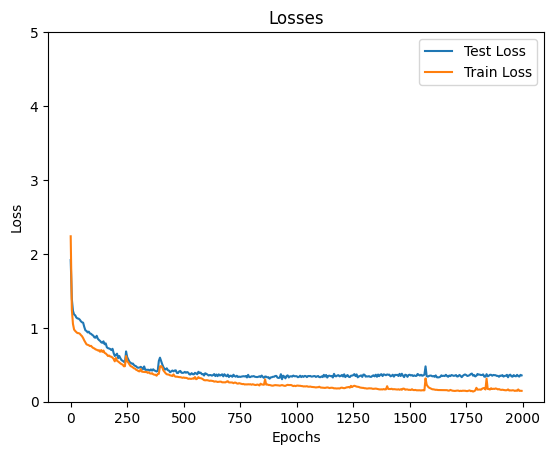

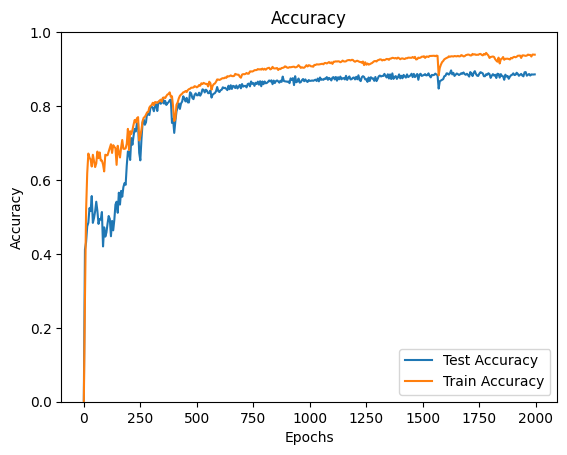

model 8
NEGU:  [603, 35, 1438, 1949, 124, 3884, 11715, 8, 5536, 7471, 10506, 3520, 13244, 43, 5450, 13384, 353, 0, 861, 7889, 6746, 7094, 46, 229, 10826, 2474, 12985, 603, 10763, 40, 8, 5, 1387, 168, 11594, 8, 6748, 2367, 1387, 13094, 7338, 11492, 10822, 43, 9978, 13381, 9609, 11288, 7728, 6127, 11324, 12981, 8791, 8800, 13404, 353, 13202, 11544, 13030, 5383, 12272, 84, 10458, 12947, 12075, 13149, 353, 9279, 6848, 9214, 690, 6409, 775, 124, 15, 861, 6900, 12981, 7259, 6850, 8, 5224, 13355, 4634, 3385, 68, 6226, 12012, 10996, 775, 11470, 12314, 5949, 168, 1006, 2781, 3752, 122, 9771, 124, 168, 11633, 5825, 5, 13409, 4254, 2124, 10622, 4458, 8, 12556, 4203, 11254, 40, 863, 40, 168, 9527, 11291, 10553, 43, 4641, 10721, 9132, 366, 10365, 13005, 124, 43, 12924, 353, 1387, 10758, 40, 7017, 11582, 8, 3355, 68, 10721, 1615, 5, 5383, 8348, 8, 8671, 15, 89, 6559, 602, 403, 46, 2030, 5, 6053, 10210, 15, 12986, 7235, 5347, 4776, 7064, 603, 5096, 4705, 13381, 8858, 13154, 3385, 9564, 4755, 3107, 86

C:\Users\subramani\AppData\Local\Temp\ipykernel_17364\2136016036.py:7: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  softmax_outputs = torch.nn.Softmax()(out)


Epoch 1/2000, Train loss: 2.2182605266571045, Train accuracy: 0.0/1.0
Test loss: 2.149301767349243, Test accuracy: 0.0/1.0
Epoch 51/2000, Train loss: 0.7987856268882751, Train accuracy: 0.6424858376220168/1.0
Test loss: 0.9946743845939636, Test accuracy: 0.4916317991631799/1.0
Epoch 101/2000, Train loss: 0.7004175782203674, Train accuracy: 0.6386616714846839/1.0
Test loss: 0.8046954274177551, Test accuracy: 0.504881450488145/1.0
Epoch 151/2000, Train loss: 0.6043028235435486, Train accuracy: 0.7055651339754475/1.0
Test loss: 0.6765323281288147, Test accuracy: 0.6105299860529986/1.0
Epoch 201/2000, Train loss: 0.5096895694732666, Train accuracy: 0.746749458783267/1.0
Test loss: 0.5890728235244751, Test accuracy: 0.6931659693165969/1.0
Epoch 251/2000, Train loss: 0.4684767723083496, Train accuracy: 0.7707963339858181/1.0
Test loss: 0.5383268594741821, Test accuracy: 0.7426778242677824/1.0
Epoch 301/2000, Train loss: 0.4099719524383545, Train accuracy: 0.812823271671355/1.0
Test loss: 0.4

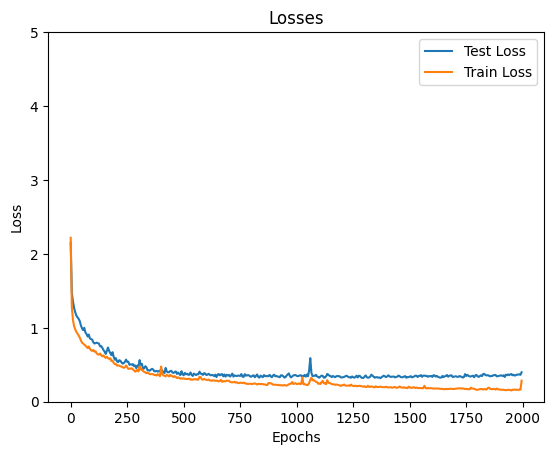

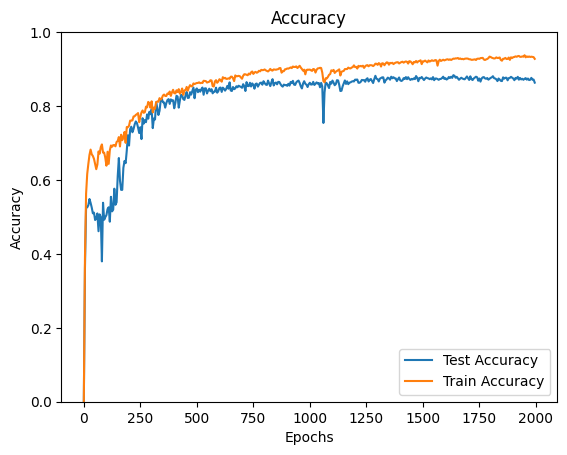

model 9
NEGU:  [5227, 6432, 40, 8, 8976, 11701, 124, 124, 71, 3304, 43, 11322, 73, 3405, 7020, 12314, 2476, 3385, 5566, 7670, 715, 8897, 74, 1168, 3884, 10365, 12588, 13094, 5, 1259, 124, 603, 7735, 7065, 8816, 9244, 3385, 9523, 11290, 11199, 2143, 13386, 11960, 12657, 3385, 12950, 366, 1613, 6360, 236, 10827, 366, 775, 3532, 142, 73, 8, 2012, 10411, 603, 10791, 1615, 15, 4153, 2014, 8751, 353, 353, 12011, 12086, 638, 13422, 365, 2773, 12363, 168, 84, 7891, 9853, 8796, 9958, 8808, 11517, 4854, 3074, 365, 365, 124, 168, 575, 5919, 15, 0, 9487, 2030, 124, 563, 43, 13174, 12986, 6887, 13018, 1362, 4318, 353, 5696, 13477, 6667, 6378, 2877, 6881, 15, 353, 8, 73, 6743, 1871, 5346, 8, 3358, 11958, 1133, 13048, 8360, 10937, 7471, 6894, 6894, 4707, 4503, 15, 560, 73, 9190, 353, 295, 6768, 84, 13380, 36, 10369, 43, 69, 8, 11640, 8, 5, 6899, 8649, 1260, 43, 8933, 353, 6264, 2775, 1436, 353, 43, 8, 11246, 3385, 43, 8066, 6432, 7019, 37, 8713, 124, 715, 8789, 7531, 11959, 8, 15, 10719, 300, 124, 89

C:\Users\subramani\AppData\Local\Temp\ipykernel_17364\2136016036.py:7: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  softmax_outputs = torch.nn.Softmax()(out)


Epoch 1/2000, Train loss: 2.117208480834961, Train accuracy: 0.0/1.0
Test loss: 1.8150603771209717, Test accuracy: 0.05404463040446304/1.0
Epoch 51/2000, Train loss: 0.8976463079452515, Train accuracy: 0.6696179722845179/1.0
Test loss: 1.1013283729553223, Test accuracy: 0.541492329149233/1.0
Epoch 101/2000, Train loss: 0.7273980975151062, Train accuracy: 0.6714976471655799/1.0
Test loss: 0.8998582363128662, Test accuracy: 0.5160390516039052/1.0
Epoch 151/2000, Train loss: 0.6761994957923889, Train accuracy: 0.672029141442294/1.0
Test loss: 0.8509081602096558, Test accuracy: 0.5359135285913529/1.0
Epoch 201/2000, Train loss: 0.583487868309021, Train accuracy: 0.7022335722897033/1.0
Test loss: 0.6854623556137085, Test accuracy: 0.6321478382147838/1.0
Epoch 251/2000, Train loss: 0.4834516644477844, Train accuracy: 0.7685407241285438/1.0
Test loss: 0.5596824884414673, Test accuracy: 0.7433751743375174/1.0
Epoch 301/2000, Train loss: 0.4300484359264374, Train accuracy: 0.7971636354208528/1.

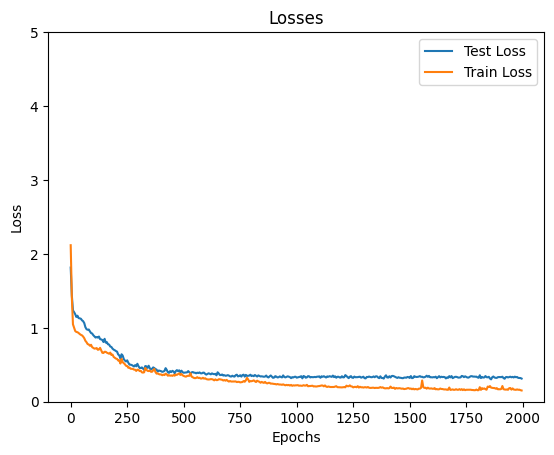

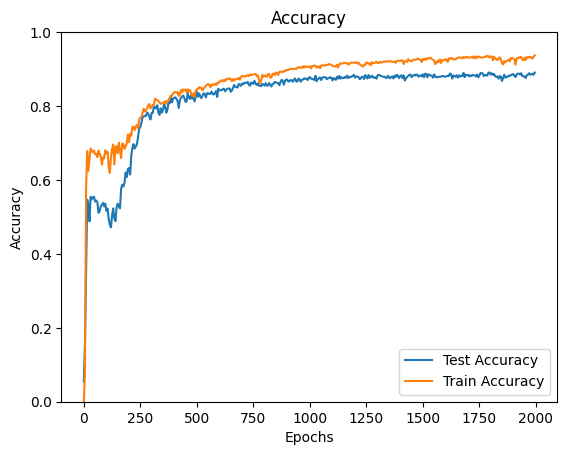

In [20]:
num_models = 10
for model_idx in range(6,num_models):
    print(f'model {model_idx}')
    train_g, train_pos_g, train_neg_g, train_e_idxs, test_pos_g, test_neg_g, test_e_idxs, neg_edge_e_list_len, num_test_size, num_train_size, pos_test_size, pos_train_size, neg_test_size, neg_train_size = generate_train_test_edges()
    torch.save(train_e_idxs,f'saved_models/train_e_idxs_{model_idx}.pt')
    torch.save(test_e_idxs,f'saved_models/test_e_idxs_{model_idx}.pt')
    torch.save(train_g,f'saved_models/train_g_{model_idx}.pt')
    torch.save(train_pos_g,f'saved_models/train_pos_g_{model_idx}.pt')
    torch.save(train_neg_g,f'saved_models/train_pos_g_{model_idx}.pt')
    torch.save(test_pos_g,f'saved_models/test_pos_g_{model_idx}.pt')
    torch.save(test_neg_g,f'saved_models/test_pos_g_{model_idx}.pt')
    
    train_e_list=[]
    test_e_list=[]
    train_v3(train_g,train_pos_g,train_neg_g,test_pos_g,test_neg_g,train_e_idxs,test_e_idxs, save_name=f'model_{model_idx}')

    torch.save(dataset,f'prs_graph_after_training_{model_idx}.pt')
    torch.save(train_e_list,f'saved_models/train_e_list_{model_idx}.pt') #for heatmap
    torch.save(test_e_list,f'saved_models/test_e_list_{model_idx}.pt')

In [21]:
def create_inference_subgraph(g, doc_nodes_id_list):
    test_s_u = [int(g.num_nodes()-1)]*len(doc_nodes_id_list)
    test_s_v = doc_nodes_id_list

    test_s_u, test_s_v = torch.tensor(test_s_u).int(), torch.tensor(test_s_v).int()

    e_feats = [0]*len(doc_nodes_id_list)

    n_feats=[g.ndata['attr'][g.num_nodes()-1]]
   
    for num in doc_nodes_id_list:
        n_feats.append(g.ndata['attr'][num])
    for i in range(g.num_nodes()-len(doc_nodes_id_list)-1):
        n_feats.append(torch.zeros(768))

    # print(n_feats)

    g_infer = dgl.graph((test_s_u, test_s_v), num_nodes=g.num_nodes())
    g_infer.edata['label'] = torch.tensor(e_feats, dtype=torch.int32)
    g_infer.ndata['attr'] = torch.stack(n_feats)
    
    return g_infer

# g_infer = create_inference_subgraph(dataset.G, doc_nodes_id_list)

In [22]:
from operator import itemgetter

def infer(g, inference_subgraph, input_text, model_num, save_name='v10_IS_neg'):

    device=torch.device('cpu')
    model = torch.load(f'saved_models/gnn_{save_name}.pt')
    pred = torch.load( f'saved_models/outlayer_{save_name}.pt')
    train_g = torch.load(f'saved_models/train_g_after_training_{save_name}.pt')
    train_e_idxs = torch.load(f'saved_models/train_e_idxs_{model_num}.pt') #change to correct train_e's

    inference_node_emb = embed_para(emb,input_text).unsqueeze(0)
    train_g.ndata['attr'][-1] = inference_node_emb
    
    h = model(train_g.to(device),
                                train_g.ndata['attr'].to(device), 
                                g.edata['label'][train_e_idxs].float().to(device))
    results, _ = pred(inference_subgraph.to(device), h)
    # return results
    result_output = torch.nn.Softmax()(results)

    result = []
    for i in range(len(result_output)):
        result.append(result_output[i][0].item())

    i = torch.tensor(result).unsqueeze(1)
    result_output = torch.cat([i, torch.tensor([int(s) for s in doc_nodes_id_list]).unsqueeze(1)], dim=1)
    sorted_results = sorted(result_output.detach().numpy(), key=itemgetter(int(dataset.edge_types['PARA_DOC'])), reverse=True)

    doc_names = []
    df_results = pd.DataFrame(sorted_results)
    for i in range(len(df_results[1])):
        doc_names.append(label_dictionary[df_results[1].values[i]])
    df_results['names'] = doc_names
    df_results['idx'] = df_results[1]
    df_results = df_results[['names'] + [int(dataset.edge_types['PARA_DOC'])]]
    df_results.columns = ['names','score']

    return df_results

    # Preview results
    # print(df_results[df_results['score']>0.50])
    # print(df_results[df_results.names.isin(['PRS 203868', 'PRS 203869'])])
    # df_results.to_csv(f'recs_output_{save_name}.csv', index=True)


# input_text='The PCDA is the power electronics assembly in the EC Avionics Module (AM), and its primary function is to distribute power from the solar array and battery to the rest of the spacecraft loads. It is comprised often slice assemblies bolted together: an ABIS, a PBC, and eight PSSs.'
# input_text = '''A DPFR was written for a L6 non-compliant performance requirement observed during brassboard thermal ambient testing. 
# The requirement was tested through MATLAB post-processing of sampled time-domain chirp voltage data from a high-speed oscilloscope. 
# Further analysis revealed that due to sampling limitations incurred by the oscilloscope and MATLAB post-processing, we could not measure the performance parameter within the desired accuracy. 
# The overall goal of the requirement (of center frequency accuracy) was reframed (to NCO frequency accuracy) such that a new test setup (involving CW tones) can indirectly verify the original requirement, which was discussed with Mark Fischman (see attached email exchange). 
# If time is permitted, the test will be performed on the CGA BB at L4 I&amp;T; otherwise, this will be performed at the FM build.'''

input_text = '''A PSS provides the power bus switch function for spacecraft subsystem and instrument loads. Power switching is performed via high and low side solid-state switch pairs, referred to as switch channels, that are commanded on or off by FSW. It is made up of 32 power switch channels that respond to Remote Serial Bus (RSB) A or B commands, with each channel consisting of a high side and low side power
switch. It also provides the output current and commanded switch states of each power switch channel as digital telemetry over RSB A and B. PSS provides an autonomous overcurrent trip capability for the high and low side of each switch channel that is resettable by command and status telemetry as to whether a switch channel is in normal mode of operation or in an overcurrent state. It also autonomously responds to a power bus undervoltage by either turning off or enforcing on designated switch channels based on their selected configuration. Each PSS includes four 5A switch channels, which can be configured to operate statically, and twenty-eight 2A switch channels, which can be configured to operate
either statically or dynamically. The PCDA includes eight PSSs to provide the necessary number of power switches required by the spacecraft loads. A switch fault may result in loss of power to a particular load, but the fault does not propagate to other loads. Therefore, the switch channel is included in the load FCR.
'''
# input_text = '''The PBC’s key functions are to regulate the power bus through control of the ABIS solar array converters
# and to manage battery charge current. It also provides the RSB command and telemetry interface to the
# REUs and to the PSSs, detects LV break wire separation, enables the propulsion and deployment power
# buses, collects power subsystem telemetry, provides telemetry through the umbilical interface, detects and
# signals power bus undervoltage conditions, and provides a solar cell IV curve tracer function. PBC single
# fault tolerance approach is N+k. The commanding to the ABIS for the voltage regulation function is also
# N+k. The PBC monitors the spacecraft power bus for any undervoltage anomalies. When it detects an
# undervoltage condition, the PBC sends UV signals to the REUs and the PSSs to turn off non-critical loads
# and enforce ON critical loads (REUs). '''
# input_text = '''The A and B propulsion power buses provide power and independent control to the latch valves, pressure
# control valves, and engine valves. There are three inhibits to meet the dual fault tolerant requirement for
# catastrophic hazards. The first inhibit consists of arm switches in the ABIS that interrupt high side of the
# propulsion power buses. The second inhibit consists of enable switches in the ABIS that interrupt the low
# side of the propulsion power buses. The arm and enable switches are commanded to close or open by
# FSW, but they can only be closed once the PBC has detected that at least one LV break wire has separated
# in order to prevent a software malfunction from enabling a propulsion bus prior to LV separation. (Separate
# breakwires and detection circuits are used for arm and enable.) The third inhibit is the FSW controlled
# power switches in the PMEs that drive the engine valves.'''
# print(input_text)

# results = infer(dataset.G, g_infer, input_text)

In [23]:
def pre_process(text):
    text=text.lower()
    return re.sub("(\\d|\\W)+"," ",text)

In [42]:
all_dfs=[]
threshold = 0.0
num_models = 5

for model_idx in range(num_models):
    g_infer = create_inference_subgraph(dataset.G, doc_nodes_id_list)
    results = infer(dataset.G, g_infer, input_text, model_idx, save_name=f'model_{model_idx}')
    all_dfs.append(results)

results = pd.concat(all_dfs)
results = pd.DataFrame(results.groupby('names')['score'].sum().sort_values(ascending=False)[:]/(num_models))
results = results[results.score>threshold]

results['Anomaly Number'] = results.index
results = results[['Anomaly Number', 'score']]
results.index = list(range(results.shape[0]))
results.to_csv(f'recs_output_{2}.csv', index=True)
results

# Getting the keyword scores for each potential recommendation
# example_keywords = ['pss', 'fpga', 'test', 'slice']
# df = pd.read_excel('PRS-europa_smap.xlsx', skiprows=1)
# if 'PRS' not in str(df['Anomaly Number'].values[0]):
#     df['Anomaly Number'] = 'PRS ' + df['Anomaly Number'].astype(str)
# df = df[df['Anomaly Number'].isin(results['Anomaly Number'])]
# df['text'] = df['Title'] + '. ' + df['Description of Incident'] + '\n' + df['Executive Summary']+ '\n' + df['Verification and Analysis']+ '\n' + df['Test Verification']
# df['text'] = df['text'].astype(str)
# df['text'] = df['text'].apply(lambda x:pre_process(x))
# df = df[['Anomaly Number', 'text']]
# kw_scores = []
# for t in df.text.values:
#     score = 0
#     for kw in example_keywords:
#         score+=t.count(kw)
#     kw_scores.append(score)
# df['kw_scores'] = kw_scores

# # Combine the Keyword Scores with the Recommendation Score
# results = results.merge(df, on='Anomaly Number', how='outer')
# results = results[results.kw_scores>0][results.score>threshold]
# results

C:\Users\subramani\AppData\Local\Temp\ipykernel_16760\3562521930.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  result_output = torch.nn.Softmax()(results)
C:\Users\subramani\AppData\Local\Temp\ipykernel_16760\3562521930.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  result_output = torch.nn.Softmax()(results)
C:\Users\subramani\AppData\Local\Temp\ipykernel_16760\3562521930.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  result_output = torch.nn.Softmax()(results)
C:\Users\subramani\AppData\Local\Temp\ipykernel_16760\3562521930.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  result_output = torch.nn.Softmax()(results)
C:\Users\subramani\AppData\Local\Temp\ipyker

,Anomaly Number,score
0,PRS 208965,0.903083
1,PRS 208027,0.895375
2,PRS 213493,0.887445
3,PRS 211614,0.883002
4,PRS 209087,0.882807
...,...,...
2314,PRS 206416,0.000025
2315,PRS 212703,0.000025
2316,PRS 48850,0.000013
2317,PRS 207025,0.000012


In [50]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
import re
import pandas as pd
import glob
from tika import parser
import pickle

def pre_process(text):
    # text=text.lower()

    return re.sub("(\\d|\\W)+"," ",text)

def get_stop_words(stop_file_path):
    """load stop words """
    
    with open(stop_file_path, 'r', encoding="utf-8") as f:
        stopwords = f.readlines()
        stop_set = set(m.strip() for m in stopwords)
        return frozenset(stop_set)

def sort_coo(coo_matrix):
    tuples = zip(coo_matrix.col, coo_matrix.data)
    return sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)

def extract_topn_from_vector(feature_names, sorted_items, topn):
    """get the feature names and tf-idf score of top n items"""
    
    #use only topn items from vector
    sorted_items = sorted_items[:topn]

    score_vals = []
    feature_vals = []

    for idx, score in sorted_items:
        fname = feature_names[idx]
        
        if score < 0.01:
            break
        #keep track of feature name and its corresponding score
        score_vals.append(round(score, 3))
        feature_vals.append(feature_names[idx])

    results= {}
    for idx in range(len(feature_vals)):
        results[feature_vals[idx]]=score_vals[idx]
    
    return results

# put the common code into several methods
def get_keywords(idx):
    #generate tf-idf for the given document
    tf_idf_vector=tfidf_transformer.transform(cv.transform([docs_test[idx]]))
    #sort the tf-idf vectors by descending order of scores
    sorted_items=sort_coo(tf_idf_vector.tocoo())
    #extract only the top n; n here is 10
    keywords=extract_topn_from_vector(feature_names,sorted_items,10)
    
    return keywords

def print_results(idx,keywords):
     # now print the results
    print("\n=====Title=====")
    print(docs_title[idx])
    print("\n=====Body=====")
    print(docs_body[idx])
    print("\n===Keywords===")
    for k in keywords:
        print(k,keywords[k])

data_df = pd.read_excel('PRS-europa_smap.xlsx', skiprows=1)
data_df['text'] = data_df['Title'] + '. ' + data_df['Description of Incident'] + '\n' + data_df['Executive Summary']+ '\n' + data_df['Test Verification'] + '\n' + data_df['Verification and Analysis']
data_df['text'] = data_df['text'].astype(str)
data_df['text'] = data_df['text'].apply(lambda x:pre_process(x))

# capture all_caps for the purpose of getting acronyms
basic_regex = r'\b([A-Z]{2,})s?\b'
expanded_regex = r'([A-Z][\w\-]+(?:[, ]{1,2}[A-Z][\w\-]+)+)[ .,]{0,2}' + ' \(' + basic_regex + '\)'
expanded_tolerant_regex = r'([A-Z][\w\-]+(?:[ ][\w\-]+)?(?:[, ]{1,2}[A-Z][\w\-]+)+)[ .,]{0,2}' + ' \(' + basic_regex + '\)'
# [, ]{1,2} and [ .,]{0,2} handle ", Inc." and similar things.
def find_acronyms_simple(text):
    results = {}#'NOAA': 'National Oceanic and Atmospheric Administration', 'SPE': 'Solar Proton Events', 'LCLUC': 'Land-Cover Land-Use Change', 'CASTLE': 'Cyber Agents for Security Testing and Learning Environments'}
    split_regex = re.compile(r'\s+')
    for m in re.finditer(r'\b([A-Za-z][a-z]*(?:\s[A-Za-z][a-z]*)+)\s+\(((?:[A-Z]\.?){2,})\)', text):
        abbreviation = m[2]
        l = sum(c.isalpha() for c in abbreviation)
        full_form = ' '.join(split_regex.split(m[1])[-l:])
        if abbreviation in results.keys():
            if len(full_form) > len(results[abbreviation]):
                results[abbreviation] = full_form
        else:
            results[abbreviation] = full_form
    return results
def find_all_acronyms(text):
    acronyms = find_acronyms(text)
    expanded = find_expanded_acronyms(text)
    acronyms = combine_acronyms(acronyms, expanded)
    return acronyms
def find_acronyms(text):
    acronyms = {}
    for m in re.finditer(basic_regex, text):
        acronym = m.group(1)
        acronyms[acronym] = ['']
    return acronyms
def find_expanded_acronyms(text):
    acronyms = {}
    for m in re.finditer(expanded_tolerant_regex, text):
        expansion, acronym = m.groups()
        expansion = fix_divided_expansion(expansion, acronym, m)
        expansion = strip_extraneous_words(expansion, acronym)
        add_expansion(acronyms, acronym, expansion)
    return acronyms
def strip_extraneous_words(expansion, acronym):
    exp = expansion.split(' ')
    # Basic case where everything matches up nicely
    if expansion[0] == acronym[0] and len(exp) <= len(acronym):
        return expansion
    # At least two words in the expansion, two characters in the acronym,
    # the first two expansion words have the same first letter,
    # BUT the acronym does not start with a double letter.
    # (might be corner cases in here, but this should get the most common cases)
    while len(exp) > 1 and len(acronym) > 1 and \
          exp[0][0] == exp[1][0] and acronym[0] != acronym[1]:
        del exp[0]
    # Simple case where the first word of the expansion doesn't match the first letter of the acronym
    while len(exp) > 0 and exp[0][0] != acronym[0]:
        del exp[0]
    expansion = ' '.join(exp)
    return expansion
def fix_divided_expansion(expansion, acronym, match):
    # Need to remember that sometimes, words are CamelCaseCapitalized or
    # have random letters pulled out from the middle of a word to make an acronym
    # more pronounceable.  So we can't rely on a count...but we can backtrack
    # and see what we come up with.
    # Use a count to see if we're in the ballpark
    words_in_expansion = re.split('\W+', expansion)
    if len(words_in_expansion) >= len(acronym):
        return expansion
    # And check caps for embedded acronyms (Acme Leopard Polident-ha = ALPha; ALPha Beta Company)
    caps_in_expansion = re.split('[A-Z]', expansion)
    if len(caps_in_expansion) >= len(acronym):
        return expansion
    # Grab a reasonable chunk of the string preceding the expansion
    start = match.start() - 100
    if start < 0: start = 0
    preceding = match.string[start:match.start()-1]
    pre = re.split('\W+', preceding)
    lowercase_count = 0
    candidates = []
    while len(pre) > 0 and lowercase_count < 2:
        curr = pre.pop()
        if curr == '': continue
        if curr[0].lower() == curr[0]:
            lowercase_count += 1
        else:
            lowercase_count = 0
        candidates.insert(0, curr)
    candidates = candidates[lowercase_count:]
    new_expansion = (' '.join(candidates) + ' ' + expansion).strip()
    return new_expansion
def combine_acronyms(first, second):
	''' Note this does not do any deep copying of the values... '''
	combined = first.copy()
	for k in second.keys():
		if k in combined:
			combined[k] = list(set(combined[k] + second[k]))
			if len(combined[k]) > 1 and '' in combined[k]:
				combined[k].remove('')
		else:
			combined[k] = second[k]
	return combined
def add_expansion(acronyms, acronym, expansion):
        if acronym not in acronyms:
            acronyms[acronym] = [expansion]
        elif expansion not in acronyms[acronym]:
            acronyms[acronym].append(expansion)
def find_unused_acronyms(found_acronyms, defined_acronyms):
    unused = {k:v for (k,v) in defined_acronyms.items() if k not in found_acronyms}
    return

# dump information to that file
cv = pickle.load(open('data/countVectorizer.pkl', 'rb'))
tfidf_transformer = pickle.load(open('data/tfidf_transformer.pkl', 'rb'))
total_n = 60 # total number of keywords to be extracted

# this is the method to extract using tfidf

# only need to run the following line once
feature_names=cv.get_feature_names_out()

keyword_collection = []

def tfidf_rerank(to_rank, input_text, df):

    extracted = find_acronyms(input_text)
    
    text = input_text.lower()
    
    tf_idf_vector=tfidf_transformer.transform(cv.transform([text]))
    curr_vector=tf_idf_vector[0]
    sorted_items=sort_coo(curr_vector.tocoo())
    keywords=extract_topn_from_vector(feature_names,sorted_items, total_n)

    acronyms = [a.lower() for a in extracted]

    for a in acronyms:
        if a not in keywords:
            keywords[a] = 0.1
        else:
            if keywords[a] < 0.1:
                keywords[a] = 0.1

    print(keywords)
    # try to score for each PRS anomaly

    prs_to_score = {}
    scores = []
    for num in to_rank:
        row = df[df['Anomaly Number'] == int(num)]
        text = row.text.values[0].lower()
        prs_to_score[str(row['Anomaly Number'])] = 0
        cnt = 0
        for k, v in keywords.items():
            cnt += v if text.count(k) > 0 else 0
        prs_to_score[str(row['Anomaly Number'])] = cnt
        scores.append(cnt)


    # round to 2 decimal places
    prs_to_score = {k: round(v, 2) for k, v in prs_to_score.items()}

    # sort the prs_to_score dictionary
    sorted_prs = sorted(prs_to_score.items(), key=lambda kv: kv[1], reverse=True)

    # return all non-zero scores
    # to return tuples of (anomaly number, score)
    # return [x for x in sorted_prs if x[1] > 0]

    # to return only anomaly numbers
    return [x[0] for x in sorted_prs if x[1] > 0], scores

list_prs = [i.split(' ')[-1] for i in results['Anomaly Number'].values]
rr, kw_scores = tfidf_rerank(list_prs, input_text, data_df)

results['kw_scores'] = kw_scores
results
rr_results = results[results.kw_scores>=results.kw_scores.max()/2][results.score>0.5]
rr_results.score = rr_results.score*rr_results.kw_scores/rr_results.kw_scores.max()
rr_results = rr_results[rr_results.score>0.25].sort_values(by=['score'], ascending=False)
rr_results.index = list(range(rr_results.shape[0]))
rr_results

c:\Users\subramani\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator CountVectorizer from version 1.0.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\subramani\AppData\Local\Temp\ipykernel_16760\4239432285.py:184: DeprecationWarning: Please use `csr_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csr` namespace is deprecated.
  tfidf_transformer = pickle.load(open('data/tfidf_transformer.pkl', 'rb'))
c:\Users\subramani\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator TfidfTransformer from version 1.0.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:


{'switch': 0.639, 'channels': 0.251, 'power': 0.245, 'channel': 0.233, 'loads': 0.193, 'side': 0.177, 'pss': 0.163, 'overcurrent': 0.143, 'rsb': 0.136, 'operate': 0.132, 'bus': 0.127, 'low': 0.126, 'spacecraft': 0.123, 'includes': 0.122, 'configured': 0.116, 'enforcing': 0.114, 'fault': 0.103, 'psss': 0.101, 'commanded': 0.099, 'solid': 0.098, 'propagate': 0.093, 'load': 0.091, 'responds': 0.088, 'autonomously': 0.088, 'undervoltage': 0.087, 'consisting': 0.086, 'autonomous': 0.086, 'pairs': 0.082, 'telemetry': 0.082, 'subsystem': 0.075, 'remote': 0.074, 'fcr': 0.1, 'respond': 0.07, 'switching': 0.066, 'serial': 0.066, 'turning': 0.064, 'loss': 0.061, 'switches': 0.059, 'trip': 0.057, 'pcda': 0.1, 'digital': 0.054, 'function': 0.051, 'instrument': 0.05, 'operation': 0.047, 'commands': 0.044, 'configuration': 0.039, 'output': 0.039, 'command': 0.037, 'fsw': 0.1}


C:\Users\subramani\AppData\Local\Temp\ipykernel_16760\4239432285.py:248: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  rr_results = results[results.kw_scores>=results.kw_scores.max()/2][results.score>0.5]


,Anomaly Number,score,kw_scores
0,PRS 214653,0.755925,3.059
1,PRS 208965,0.600186,2.033
2,PRS 206967,0.586409,2.080
3,PRS 209991,0.568877,2.227
4,PRS 212485,0.565065,2.156
5,PRS 210278,0.549218,2.044
6,PRS 211737,0.531096,2.732
7,PRS 213332,0.529691,2.243
8,PRS 211262,0.521429,1.953
9,PRS 206350,0.504038,2.069


In [46]:
rr_results[rr_results['Anomaly Number']=='PRS 208027']

,Anomaly Number,score,kw_scores


In [80]:
results[results['Anomaly Number']=="PRS 206595"]

,Anomaly Number,score,kw_scores
260,PRS 206595,0.67073,2.828


In [77]:
rr_results[rr_results['Anomaly Number']=="PRS 206595"]

,Anomaly Number,score,kw_scores
64,PRS 206595,0.673819,2.828


In [56]:
rr_results = results[results.score>0.5].sort_values(by=['kw_scores'], ascending=False)
rr_results.index = list(range(rr_results.shape[0]))
rr_results[rr_results['Anomaly Number']=="PRS 210768"]


,Anomaly Number,score,kw_scores
101,PRS 210768,0.512154,1.035


In [44]:
results[results['Anomaly Number']=="PRS 210768"]

,Anomaly Number,score,kw_scores
588,PRS 210768,0.512154,1.397


In [48]:
rr_results

,Anomaly Number,score,kw_scores
260,PRS 206595,0.670730,2.828
202,PRS 210571,0.690551,2.641
12,PRS 208609,0.830618,2.493
112,PRS 211021,0.730319,2.482
351,PRS 211401,0.637487,2.457
...,...,...,...
291,PRS 209303,0.659397,0.000
551,PRS 215996,0.539670,0.000
289,PRS 209911,0.659554,0.000
108,PRS 215455,0.732233,0.000


In [123]:
#----------------CODE TO PRINT TRUE EDGES OF GRAPH AND WHETHER THEY WERE CLASSIFIED CORRECTLY DURING TRAINING-------------------
train_eid_dict={}
test_eid_dict={}
for new_id, old_id in enumerate(train_e_idxs):
    train_eid_dict[new_id]=old_id
for new_id, old_id in enumerate(test_e_idxs):
    test_eid_dict[new_id]=old_id

print('TRAINING')
for id in range(max(train_e_idxs)):
    if id in train_eid_dict.keys():
        u,v=dataset.G.find_edges(train_eid_dict[id])
        print('(',label_dictionary[u.item()],'->',label_dictionary[v.item()],'):',train_e_list[id])

print()
print('TESTING')
for id in range(max(test_e_idxs)):
    if id in test_eid_dict.keys():
        u,v=dataset.G.find_edges(test_eid_dict[id])
        print('(',label_dictionary[u.item()],'->',label_dictionary[v.item()],'):',test_e_list[id])

NameError: name 'train_e_idxs' is not defined

In [186]:
from sklearn.preprocessing import normalize

#create confusion matrix for training and testing data
def create_conf_matrix(mode):

    conf_matrix = np.zeros([9,9])
    for i in range(9):
        for j in range(9):
            if mode=='train':
                conf_matrix[i][j] = train_edge_classification_dict[i][edge_id_to_label_dict[j]]
            else:
                conf_matrix[i][j] = test_edge_classification_dict[i][edge_id_to_label_dict[j]]
    normed_matrix = normalize(conf_matrix, axis=1, norm='l1')

    return normed_matrix

train_matrx = create_conf_matrix('train')
test_matrix = create_conf_matrix('test')



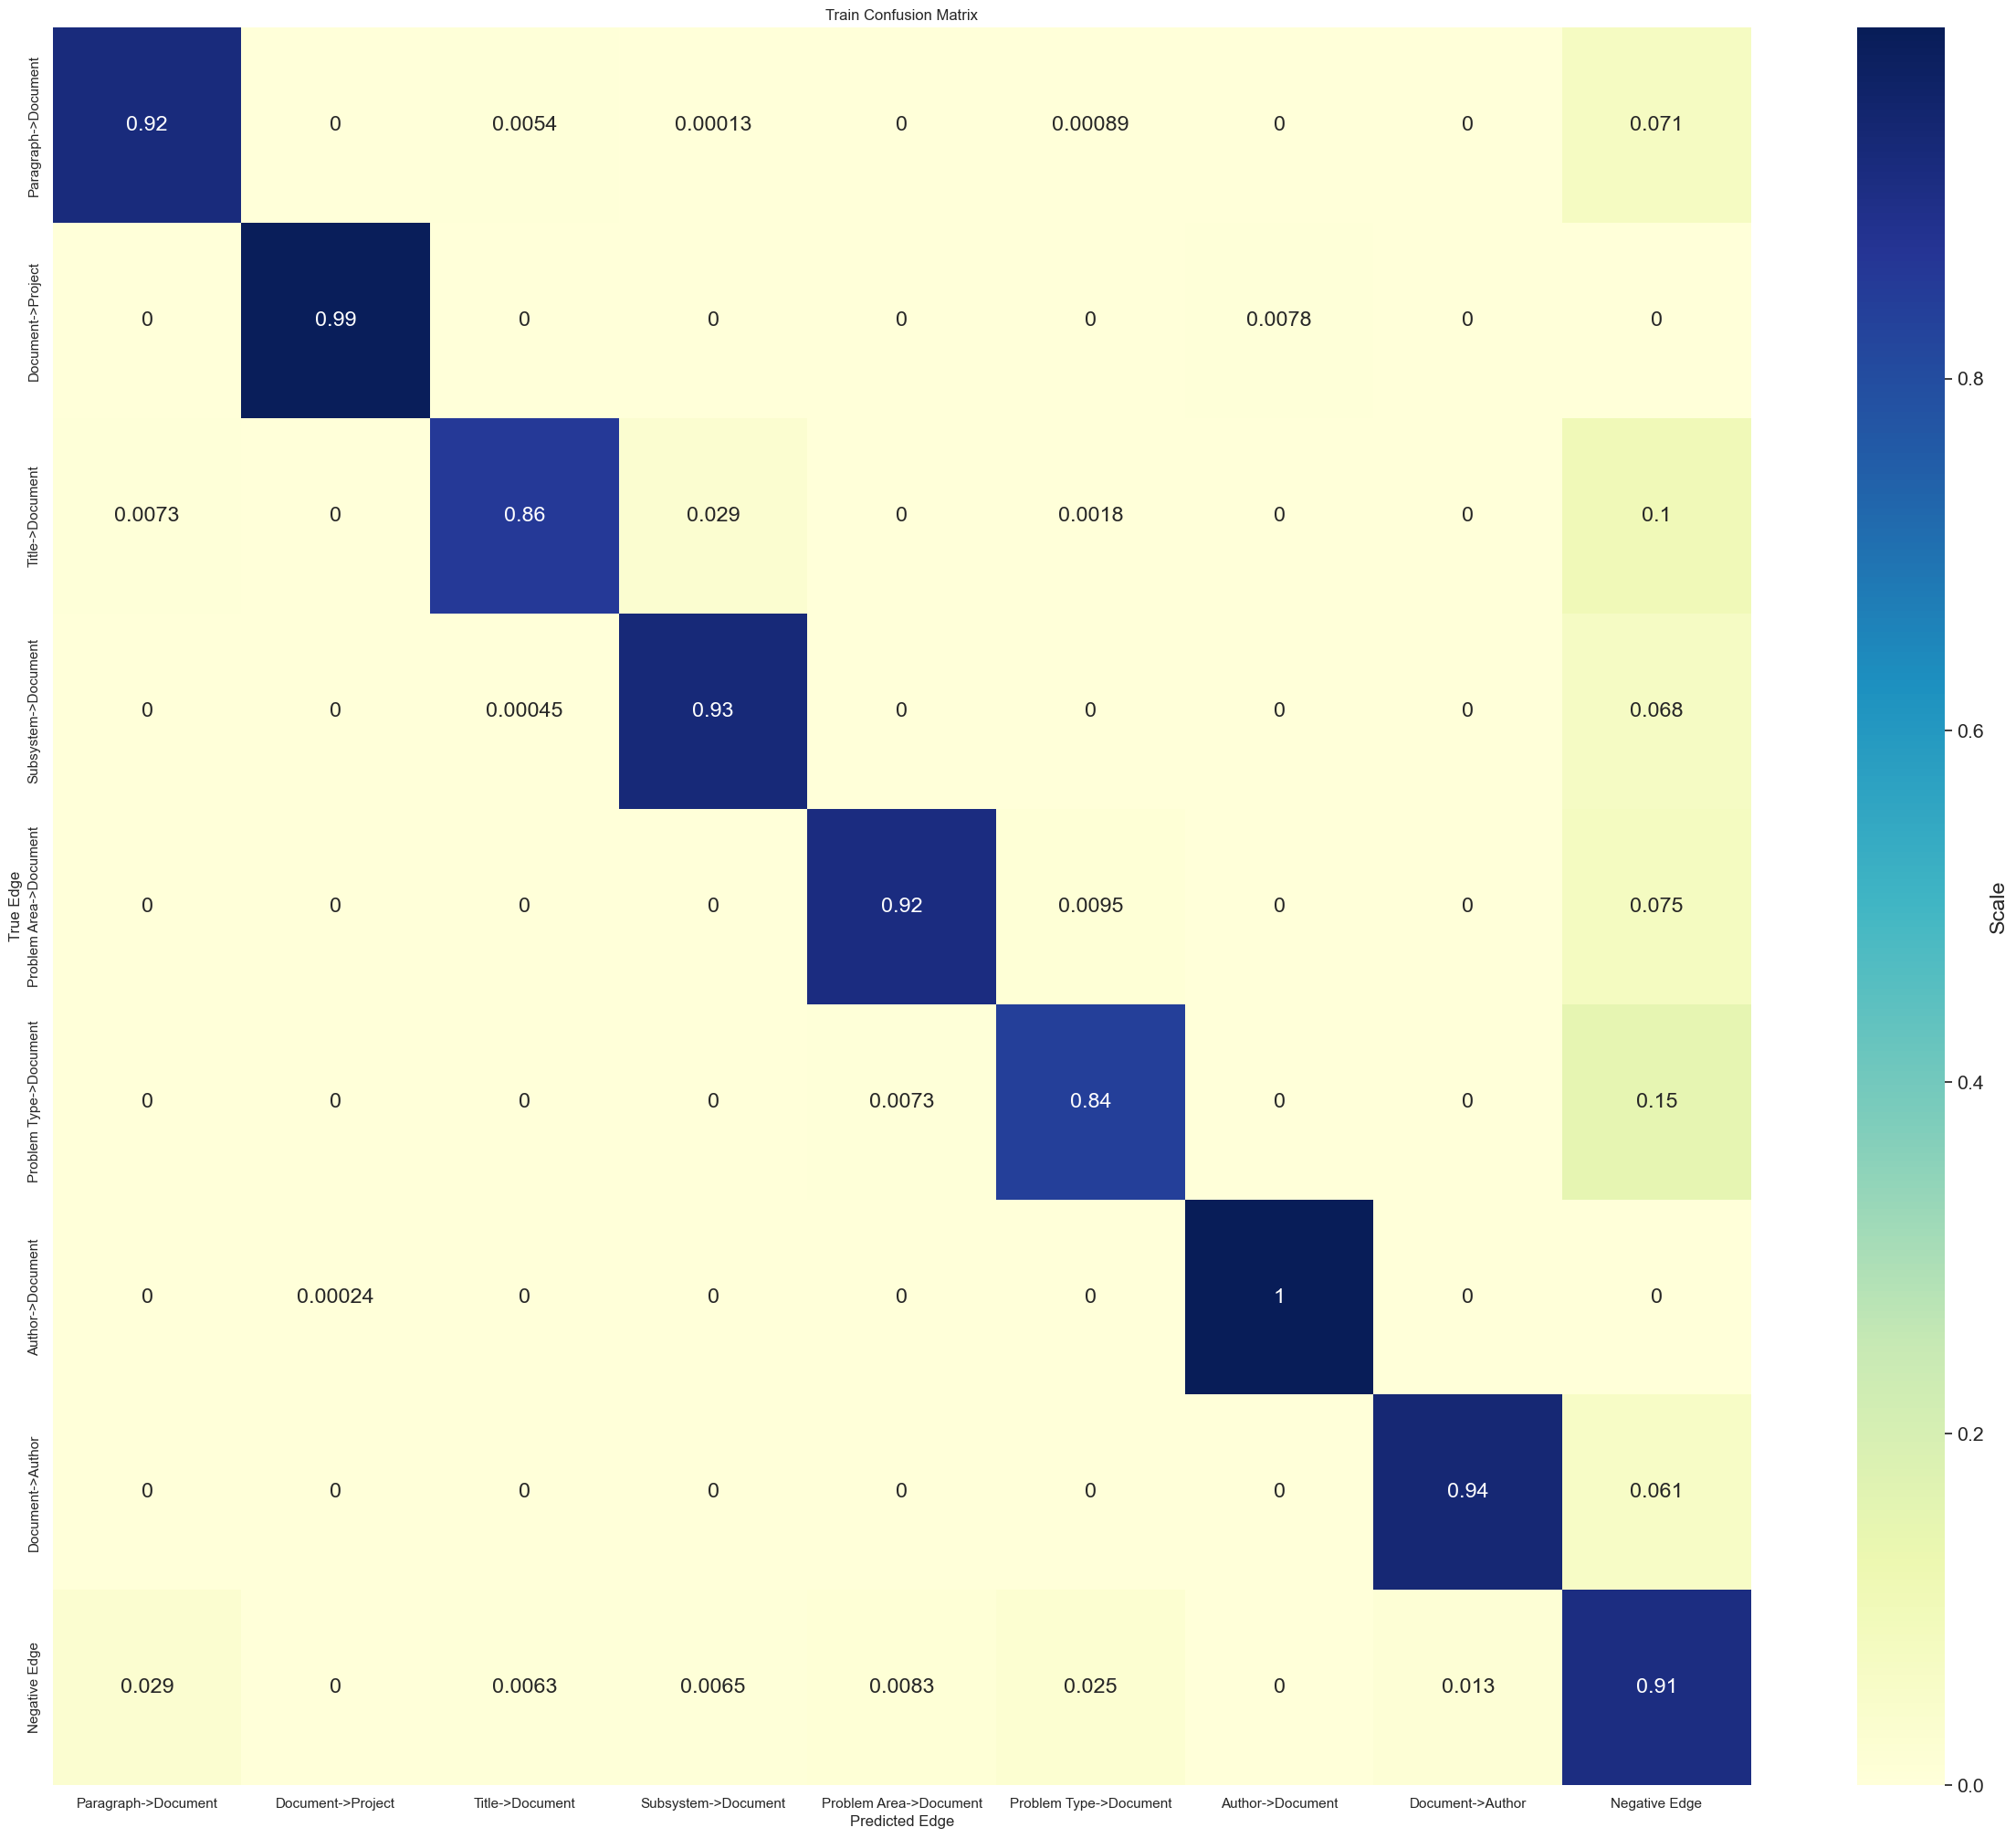

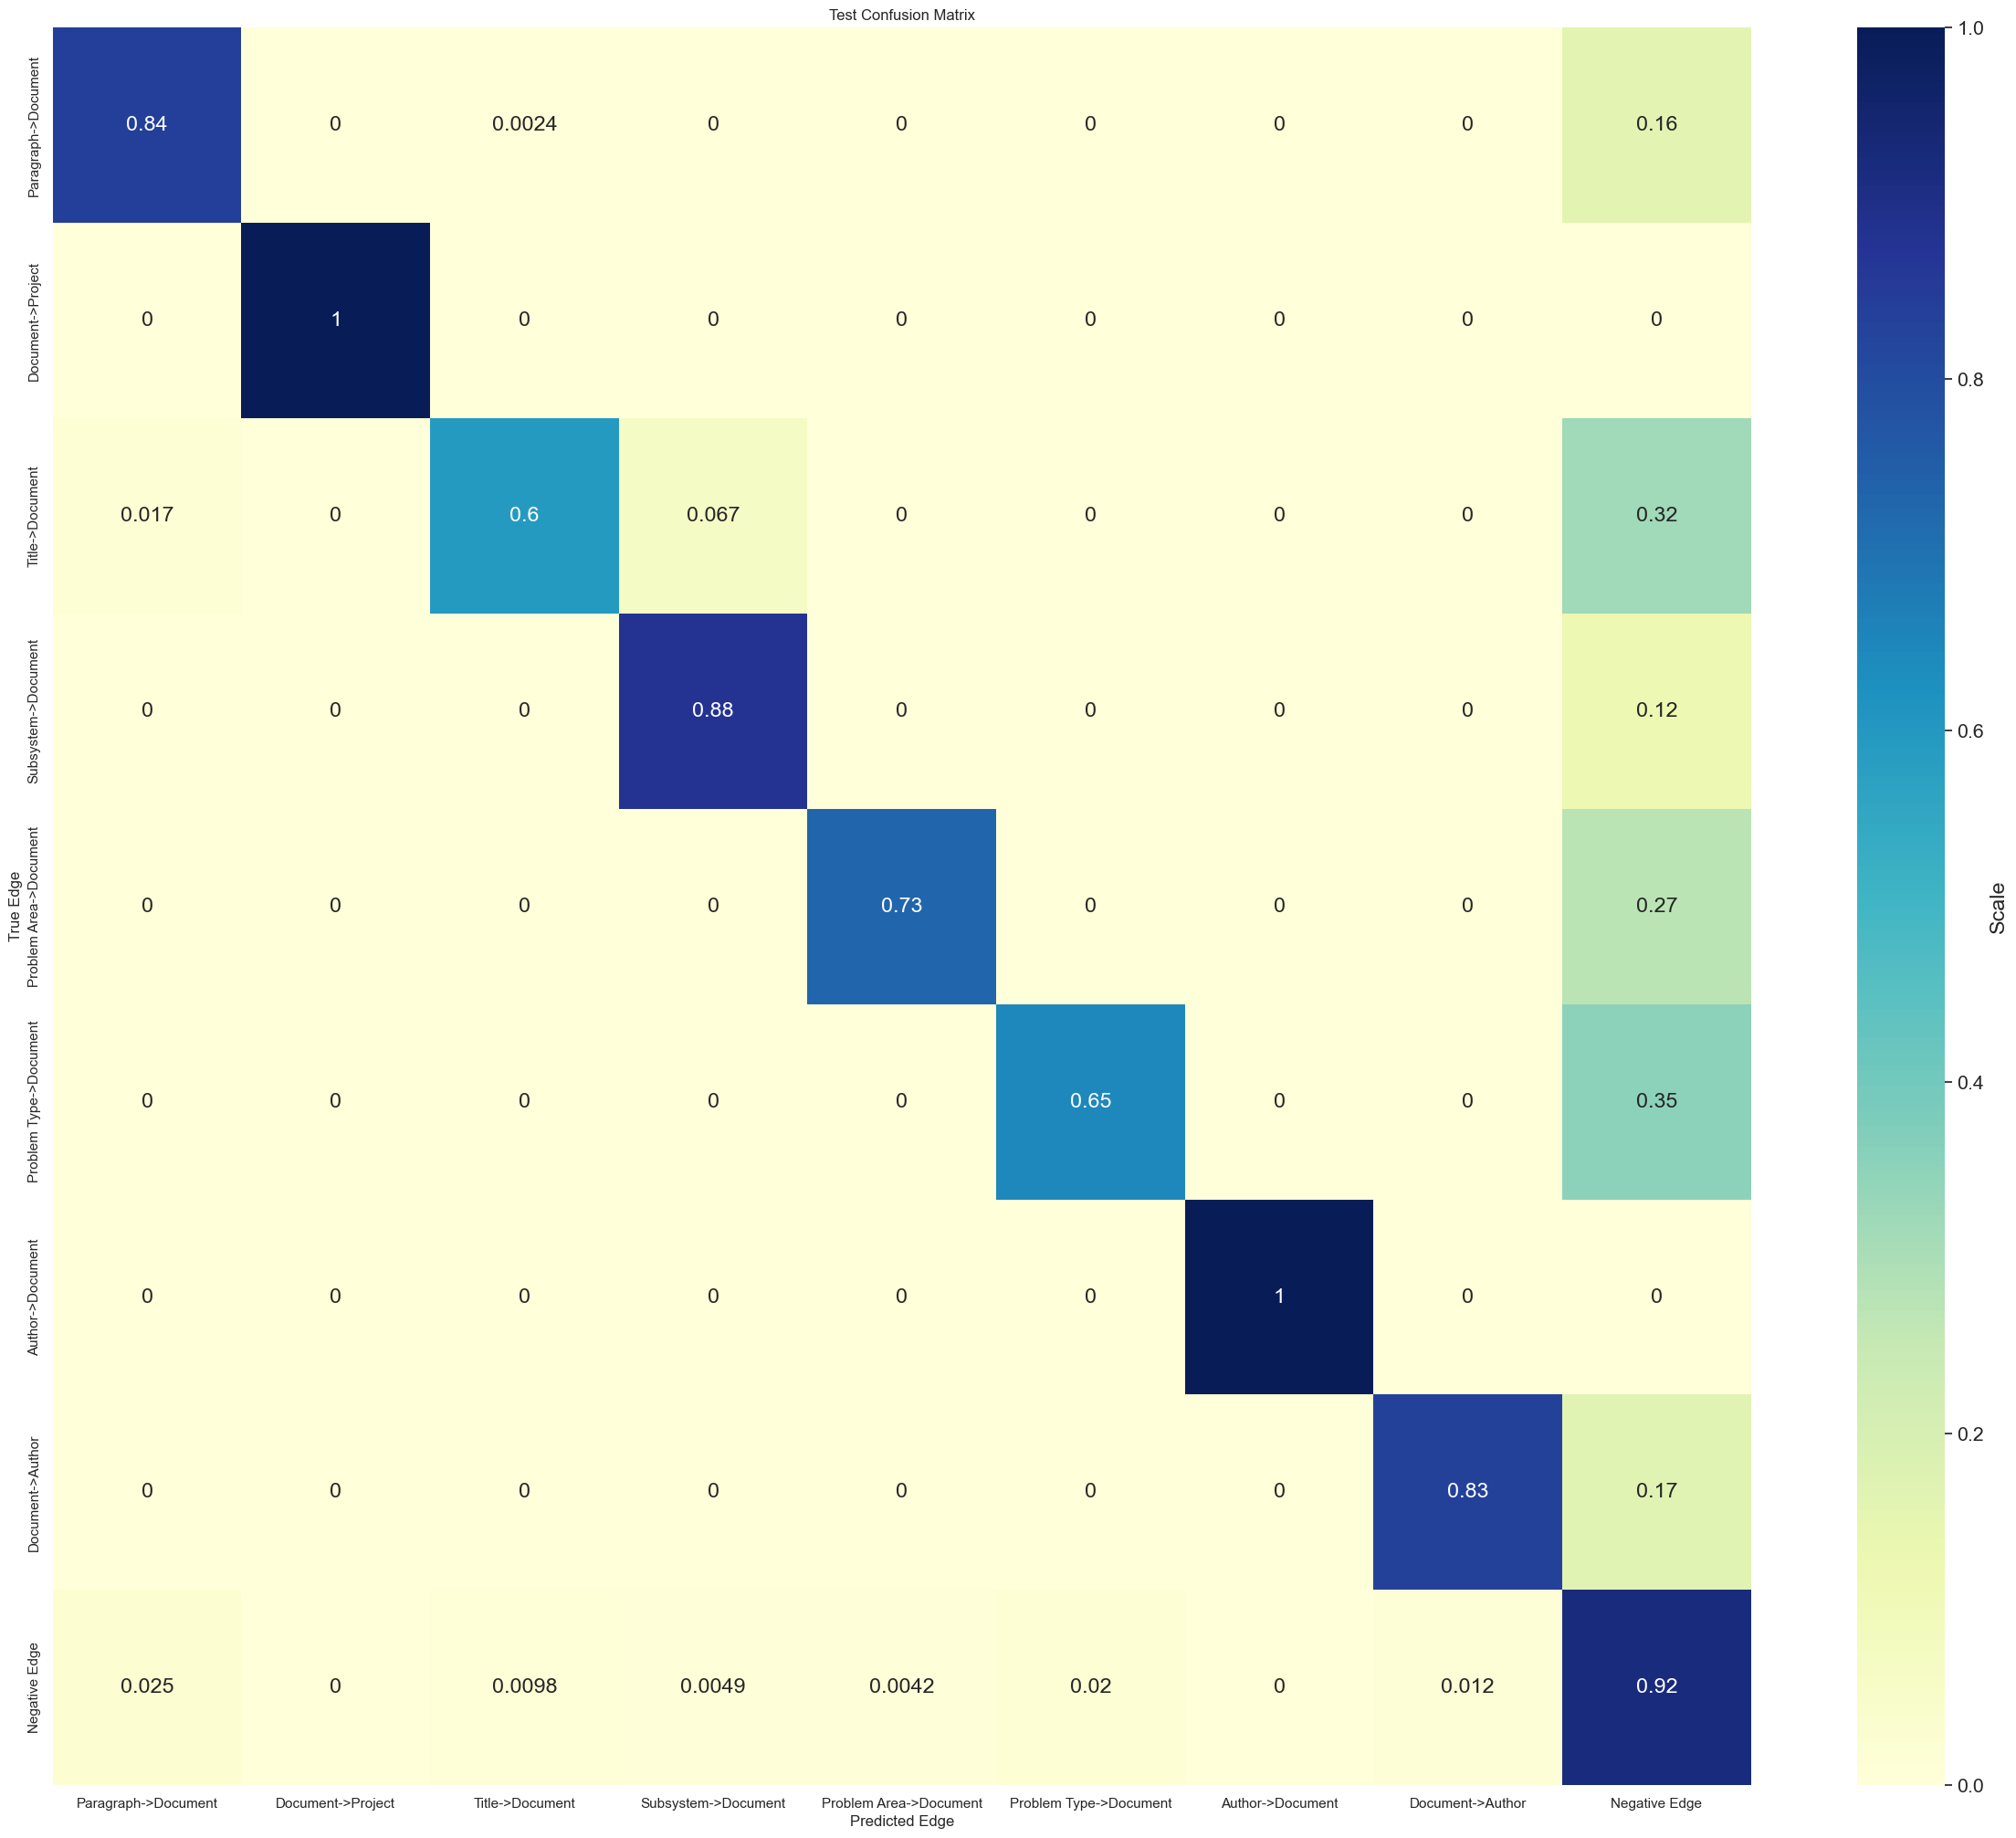

In [187]:
import seaborn

# plot confusion matrix using a heatmap
 
def plot_confusion_matrix(data, labels, output_filename,mode):
    """Plot confusion matrix using heatmap.
 
    Args:
        data (list of list): List of lists with confusion matrix data.
        labels (list): Labels which will be plotted across x and y axis.
        output_filename (str): Path to output file.
 
    """
    seaborn.set(color_codes=True)
    plt.figure(1, figsize=(30,25))
 
    plt.title(mode+"Confusion Matrix")
 
    seaborn.set(font_scale=1.4)
    ax = seaborn.heatmap(data, annot=True, cmap="YlGnBu", cbar_kws={'label': 'Scale'})
 
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)
 
    ax.set(ylabel="True Edge", xlabel="Predicted Edge")
 
    plt.savefig(output_filename, bbox_inches='tight', dpi=300)
    plt.show()

# define labels
matrix_elabels = ['Paragraph->Document', 'Document->Project', 'Title->Document', 'Subsystem->Document','Problem Area->Document','Problem Type->Document','Author->Document','Document->Author','Negative Edge']
 
 
# create confusion matrix
plot_confusion_matrix(train_matrx, matrix_elabels, "train_confusion_matrix.png",'Train ')
plot_confusion_matrix(test_matrix,matrix_elabels,"test_confusion_matrix.png",'Test ')

In [74]:
#---------------ALL CODE IN CELLS BELOW IS FOR SUBGRAPH PREDICTION----------------------

# code to generate ground truth dataset
true_subgraphs = []
false_subgraphs = []

for i in range(2,len(all_rows)):
    if all_rows[i][0].value is None or all_rows[i][0].value=='':
        break

    for j in range(2,len(all_rows)):

        if all_rows[j][0].value is None or all_rows[j][0].value=='':
            break

        node_list=[]
        node_list.append(node_dictionary['PRS ' + str(all_rows[i][0].value)]['node_id'])

        for node in node_dictionary:
                if node_dictionary[node]['node_type'] == 'paragraph node' and 'parent_prs' in node_dictionary[node].keys() and node_dictionary[node]['parent_prs'] == all_rows[j][0].value:
                    node_list.append(node_dictionary[node]['node_id'])

        subgraph = dataset.subgraph(node_list)

        if i == j:
            true_subgraphs.append(subgraph)
        else:
            subgraph_nodes = subgraph.nodes()
            for k in range(1,len(subgraph_nodes)):
                subgraph.add_edges([subgraph_nodes[k]],[subgraph_nodes[0]])
            false_subgraphs.append(subgraph)


In [75]:
# create same number of true and false subgraphs

import secrets

shortened_false_list = []

for i in range(len(true_subgraphs)):
    chosen = secrets.choice(false_subgraphs)
    shortened_false_list.append(chosen)
    false_subgraphs.remove(chosen)


In [76]:
# add vectors and consolidate graph dataset
graph_list = []
tensor_list = []
for graph in true_subgraphs:
    graph_list.append(graph)
    tensor_list.append(1.0)
for graph in shortened_false_list:
    graph_list.append(graph)
    tensor_list.append(0.0)

In [77]:
# shuffle lists so that the test data loader does not only have false subgraphs
from sklearn.utils import shuffle

# shuffle graph list to create random batches
graph_list, tensor_list = shuffle(graph_list, tensor_list, random_state=0)

In [78]:
# dataset object to store true and false subgraphs with its labels

class SyntheticDataset(dgl.data.DGLDataset):
    def __init__(self):
        super().__init__(name="synthetic")

    def process(self):
        self.graphs = graph_list
        self.labels = torch.LongTensor(tensor_list)
        self.dim_nfeats = 768
        self.gclasses = 2

    def __getitem__(self, i):
        return self.graphs[i], self.labels[i]

    def __len__(self):
        return len(self.graphs)

In [79]:
from dgl.dataloading import GraphDataLoader
from torch.utils.data.sampler import SubsetRandomSampler

data = SyntheticDataset()

#create training and testing data split
num_examples = len(data)
num_train = int(num_examples*0.8)

train_sampler = SubsetRandomSampler(torch.arange(num_train))
test_sampler = SubsetRandomSampler(torch.arange(num_train, num_examples))

train_dataloader = GraphDataLoader(data,sampler=train_sampler,batch_size=5,drop_last=False)
test_dataloader = GraphDataLoader(data,sampler=test_sampler,batch_size=5,drop_last=False)

In [80]:
from models.GNN_Model import GraphValidator
from utils import construct_graph, create_graph_dataset, infer_subgraph_scores, iterate_dataloader, plt_GV_curves

if torch.cuda.is_available(): device = torch.device("cuda:0" ) 
else: device = torch.device("cpu" ) 

In [81]:
# Create the model with given dimensions
n_feats = 256 # input feature - BERT Embedding 
h_feats = 16 # nodes in hidden layer
out_feats = 1 # Binary Classification
lr = 0.002
epochs = 150
save_iter = 10 # Save after every save_iter epochs
save_name = 'validation_gnn_v10'
batch_size = 128

In [82]:
model = GraphValidator(n_feats, h_feats, out_feats).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = torch.nn.BCELoss()

In [83]:
metrics = { 'Loss': {'train_loss': [], 'test_loss': []}, 
            'Accuracy': {'train_accuracy': [], 'test_accuracy': []}}

for epoch in range(epochs):
    
    train_loss, train_accuracy = iterate_dataloader(train_dataloader, model, criterion, optimizer, train=True)
    test_loss, test_accuracy = iterate_dataloader(test_dataloader, model, criterion, optimizer, train=False)
   
    metrics['Loss']['train_loss'].append(train_loss)
    metrics['Loss']['test_loss'].append(test_loss)
    metrics['Accuracy']['train_accuracy'].append(train_accuracy)
    metrics['Accuracy']['test_accuracy'].append(test_accuracy)
    
    print(f'Epoch {epoch}/{epochs}, Train Loss: {train_loss} Test Loss: {test_loss}')
    print(f'Train Accuracy: {train_accuracy}, Test Accuracy: {test_accuracy}')
    print()
    #if epoch%20 == 0: torch.save(model, f'./params/{save_name}.pt')

Epoch 0/150, Train Loss: 0.807122867840987 Test Loss: 0.7156612958226886
Train Accuracy: 0.3681201134853816, Test Accuracy: 0.3386309523809524

Epoch 1/150, Train Loss: 0.7255423607734534 Test Loss: 0.7320876887866429
Train Accuracy: 0.5268914039412812, Test Accuracy: 0.4397023809523809

Epoch 2/150, Train Loss: 0.7338026051337903 Test Loss: 0.725060156413487
Train Accuracy: 0.46907645379064294, Test Accuracy: 0.4345833333333333

Epoch 3/150, Train Loss: 0.6957614421844482 Test Loss: 0.8161250182560512
Train Accuracy: 0.5826182715466526, Test Accuracy: 0.3383333333333333

Epoch 4/150, Train Loss: 0.6846904938037579 Test Loss: 0.7227862136704581
Train Accuracy: 0.5753954504333347, Test Accuracy: 0.3264285714285714

Epoch 5/150, Train Loss: 0.6800374755492578 Test Loss: 0.7720932960510254
Train Accuracy: 0.5312039079550029, Test Accuracy: 0.3713690476190476

Epoch 6/150, Train Loss: 0.6596326197569187 Test Loss: 0.8017913188253131
Train Accuracy: 0.644928908823705, Test Accuracy: 0.54773

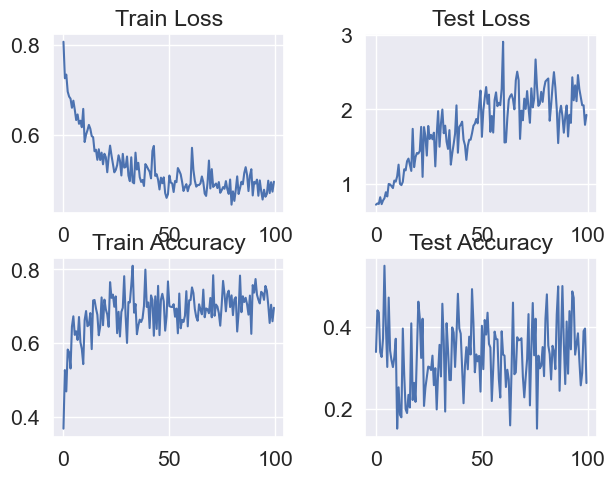

In [84]:
import matplotlib.pyplot as plt

# plot accuracy and loss

plt.figure()

plt.subplot(221)
plt.title('Train Loss')
t = np.arange(0., 100., 100/150)
plt.plot(t,metrics['Loss']['train_loss'])

plt.subplot(222)
plt.title('Test Loss')
t = np.arange(0., 100., 100/150)
plt.plot(t,metrics['Loss']['test_loss'])

plt.subplot(223)
plt.title('Train Accuracy')
t = np.arange(0., 100., 100/150)
plt.plot(t,metrics['Accuracy']['train_accuracy'])

plt.subplot(224)
plt.title('Test Accuracy')
t = np.arange(0., 100., 100/150)
plt.plot(t,metrics['Accuracy']['test_accuracy'])

plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25,
                    wspace=0.35)

plt.show()


In [85]:
from bokeh.io import output_notebook, show, save
from bokeh.models import Range1d, Circle, ColumnDataSource, MultiLine
from bokeh.plotting import figure
from bokeh.plotting import from_networkx
import networkx
output_notebook()

#Choose a title!
title = 'SMAP GNN'

nx_G1 = dataset.G.to_networkx()
nxgraphcopy = nx_G1.copy()

for i in range(len(label_dictionary)):
  nxgraphcopy.nodes[i]["title"] = label_dictionary[i]

#Establish which categories will appear when hovering over each node
HOVER_TOOLTIPS = [("Title", "@title")]

#Create a plot — set dimensions, toolbar, and title
plot = figure(tooltips = HOVER_TOOLTIPS,
              tools="pan,wheel_zoom,save,reset", active_scroll='wheel_zoom',
            x_range=Range1d(-10.1, 10.1), y_range=Range1d(-10.1, 10.1), title=title, width=1000, height=1000)

#Create a network graph object with spring layout
# https://networkx.github.io/documentation/networkx-1.9/reference/generated/networkx.drawing.layout.spring_layout.html
#network_graph = from_networkx(G, networkx.spring_layout, scale=10, center=(0, 0))
network_graph = from_networkx(nxgraphcopy, networkx.spring_layout, scale=10, center=(0,0))

network_graph.node_renderer.data_source.data['colors'] = color_map
#Set node size and color
network_graph.node_renderer.glyph = Circle(size=15, fill_color='colors')

#Set edge opacity and width
network_graph.edge_renderer.glyph = MultiLine(line_alpha=0.5, line_width=1)

#Add network graph to the plot
plot.renderers.append(network_graph)

show(plot)
save(plot, filename=f"{title}.html")

Loading BokehJS ...

C:\Users\subramani\AppData\Local\Temp\ipykernel_14444\43206454.py:41: UserWarning: save() called but no resources were supplied and output_file(...) was never called, defaulting to resources.CDN
  save(plot, filename=f"{title}.html")
C:\Users\subramani\AppData\Local\Temp\ipykernel_14444\43206454.py:41: UserWarning: save() called but no title was supplied and output_file(...) was never called, using default title 'Bokeh Plot'
  save(plot, filename=f"{title}.html")


'c:\\Users\\subramani\\OneDrive - JPL\\customized_knowledge_base\\SMAP GNN.html'